In [1]:
from collections import OrderedDict as odict
import copy
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import healpy
from scipy.interpolate import interp1d
from astropy import units, constants

import aipy 
import hera_sim
import uvtools
import hera_cal
import linsolve

from pyuvdata import UVBeam, utils
from uvtools.dspec import dayenu_filter, fourier_filter, gen_window
from uvtools.utils import FFT, fourier_freqs

%matplotlib inline

/home/bobby/HERA/dev/v1.0.0/hera_sim/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")


In [2]:
paper_dir = "/home/bobby/HERA/Papers/Wedge_Elimination/"
plot_dir = os.path.join(paper_dir, "Plots/")

# Utility Functions

In [6]:
def linear_array(ruler, base_sep=1):
    """
    Construct a linear array given a Golomb ruler.
    
    Parameters
    ----------
    ruler : array-like of int
        1D-array whose entries mark positions on a Golomb ruler.
        
    base_sep : float, optional
        Amount to scale all antenna positions by--this is effectively 
        the length of the shortest baseline in the array. Default is 1.
        
    Returns
    -------
    antpos : dict
        Dictionary whose keys are antenna numbers and whose values are the 
        corresponding antenna positions. The array is EW oriented and 
        returned in ENU coordinates.
    """
    return {ant : np.array([base_sep * pos, 0, 0]) for ant, pos in enumerate(ruler)}

In [7]:
def construct_baselines(antpos, include_autos=False):
    """
    Construct a baseline array given antenna positions.
    
    Parameters
    ----------
    ruler : array-like of int
        1D-array whose entries mark positions on a Golomb ruler.
        
    Returns
    -------
    baselines : dict
        Dictionary whose keys are antenna pairs and whose values are the 
        corresponding baseline lengths.
    """
    if include_autos:
        cond = lambda i, j : i >= j
    else:
        cond = lambda i, j : i > j
        
    return {
        (j,i) : xi-xj
        for i, xi in antpos.items()
        for j, xj in antpos.items()
        if cond(i,j)
    }

In [8]:
def get_u_coverage(antpos, freqs):
    """
    Determine the number of times each u-mode for an array is sampled.
    
    Parameters
    ----------
    antpos : dict
        Dictionary whose entries are antenna number and whose values are 
        antenna positions.
        
    freqs : array-like of float
        1D-array corresponding to the frequencies observed in the simulation.
        Should be provided in units of GHz.
        
    Returns
    -------
    u_cov : np.ndarray of int
        Array whose entries count the number of times the corresponding integer 
        u-mode is sampled by the array.
    """
    baselines = construct_baselines(antpos)
    u_max = np.ceil(np.asarray(list(baselines.values())).max()) * freqs[-1]
    u_cov = np.zeros(int(u_max) + 1)
    for bl_ns in baselines.values():
        u_min = bl_ns[0] * freqs[0]
        u_max = bl_ns[0] * freqs[-1]
        u_cov[int(np.floor(u_min)):int(np.ceil(u_max))] += 1
        
    return u_cov

In [10]:
# Option 1: Make a simple Gaussian Beam
def beam_gaussian(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    """
    Construct a (possibly chromatic) Gaussian beam.
    
    Parameters
    ----------
    xs : array-like of float
        Sky coordinates to evaluate the beam at, with 0 being at zenith.
        Measured in radians.
        
    fqs : array-like of float
        Frequencies to evaluate the beam at, measured in GHz.
        
    width : float, optional
        FWHM of the beam at the reference frequency, measured in radians.
        Default 0.2 radians.
        
    mfreq : float, optional
        Reference frequency for making a chromatic beam, measured in GHz.
        Default 150 MHz.
        
    chromatic : bool, optional
        Whether to make the beam frequency-dependent. Default True.
        
    Returns
    -------
    response : ndarray of float
        Beam response at the specified sky coordinates and frequencies.
    """
    xs = np.array(xs)
    xs.shape = (xs.size,1)
    fqs = np.array(fqs)
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.exp(-(xs**2) / (2 * np.sin(width)**2)).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp

# Option 2: Sinc function
def beam_sinc(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    """
    Create a sinc-function beam response. Same parameters as gaussian_beam.
    """
    xs = np.array(xs)
    xs.shape = (xs.size,1)
    fqs = np.array(fqs)
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.sinc(xs / np.sin(width) / 2).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp

In [11]:
def mock_sky_signals(freqs, mfreq=0.150, npix=2**7, flux_densities=None, spectral_indices=None,
                     eor_amp=1e-5):
    """
    Generate mock sky signals (foregrounds and EoR).
    """
    if flux_densities is None:
        flux_densities = np.random.uniform(0, 10, size=(npix, 1))
    if spectral_indices is None:
        spectral_indices = np.random.uniform(-2, -1, size=(npix, 1))
        
    achromatic_fg = np.outer(flux_densities, np.ones(freqs.size))
    chromatic_fg = flux_densities * (freqs / mfreq)**spectral_indices
    eor = np.random.uniform(0, eor_amp, size=(npix, freqs.size))
    intensities = {
        "F" : chromatic_fg,
        "f" : achromatic_fg,
        "E" : eor
    }
    return intensities

In [12]:
def construct_beam_dict(xs, freqs, width=0.2, mfreq=0.15):
    """
    Calculate the primary beam at each pixel for each frequency for 
    chromatic and achromatic versions of a Gaussian beam and a sinc beam.
    
    Parameters
    ----------
    xs : array-like of float
        Sky coordinate, transformed to the interval [-1,1] (e.g. horizon-to-horizon
        or a subset thereof).
        
    freqs : array-like of float
        Frequencies at which to evaluate the beam, in units of GHz.
        
    width : float, optional
        FWHM of the beam at the reference frequency ``mfreq``, in units of radians.
        Default is 0.2 radians (about 11.5 degrees).
        
    mfreq : float, optional
        Reference frequency for adding chromaticity to the beam, in units of GHz. 
        A chromatic beam is wider at lower frequencies. Default is 0.15 GHz.
        
    Returns
    -------
    beam_dict : dict
        Dictionary whose keys are single letter identifiers of the beam type and 
        whose values are the corresponding beam responses with shape (xs.size, freqs.size).
    """
    beams = {
        "G" : beam_gaussian(xs, freqs, width, mfreq, True),
        "g" : beam_gaussian(xs, freqs, width, mfreq, False),
        "S" : beam_sinc(xs, freqs, width, mfreq, True),
        "s" : beam_sinc(xs, freqs, width, mfreq, False)
    }
    return beams

In [13]:
def construct_true_visibilities(antpos, xs, freqs, intensities=None, beams=None,
                                sky_kwargs=None, beam_kwargs=None):
    """
    Mock up some visibilities.
    """
    sky_kwargs = sky_kwargs or {}
    beam_kwargs = beam_kwargs or {}
    
    intensities = intensities or mock_sky_signals(freqs, **sky_kwargs)
    beams = beams or construct_beam_dict(xs, freqs, **beam_kwargs)
    
    # initialize the visibility dictionary
    vis_dict = {}
    for beam_key in beams:
        for sky_key in intensities:
            vis_dict[beam_key + sky_key] = np.zeros(
                (freqs.size, len(antpos), len(antpos)), dtype=np.complex
            )
            
    dx = np.median(np.diff(xs))
    baselines = construct_baselines(antpos)
    for antpair, bl in baselines.items():
        ai, aj = antpair
        blx, bly, blz = bl
        # use the average of the fringe over the pixel
        fringe_1 = np.exp(-2j * np.pi * blx * np.outer(xs + dx/2, freqs))
        fringe_2 = np.exp(-2j * np.pi * blx * np.outer(xs - dx/2, freqs))
        fringe = (fringe_1 - fringe_2) / (-2j * np.pi * blx * freqs * dx)
        # calculate the visibilities for each beam/fg model
        for beam_sky, vis in vis_dict.items():
            beam, sky = beam_sky
            beam_sq = beams[beam]**2
            Isky = intensities[sky]
            V_ij = np.sum(beam_sq * Isky * fringe * dx, axis=0)
            vis[:, ai, aj] = V_ij
            vis[:, aj, ai] = V_ij.conj()
            
    return vis_dict

In [14]:
def construct_interp_vis_dict(ant1, ant2, antpos, freqs, vis, 
                              coverage=None, cov_thresh=None,
                              umin=None, umax=None, 
                              show_progress=False,
                              **kwargs):
    """
    Do all the things.
    
    Parameters
    ----------
    ant1, ant2 : int
        Antennas specifying which baseline to construct the visibility dictionary 
        for.
        
    antpos : dict
        Dictionary whose keys are antenna numbers and whose values are the 
        corresponding positions for each antenna.
        
    freqs : array-like of float
        Frequencies for which the true visibilities are evaluated. Should be 
        in units of GHz.
        
    vis : dict
        Dictionary containing the true visibilities.
        
    coverage : array-like of int, optional
        Array whose entries count the number of baselines that sample the u-mode 
        corresponding to the index of the entry. If not provided, then it is 
        computed from the ``antpos`` dict and the ``freqs`` array.
        
    cov_thresh : int
        If provided, specifies the minimum number of times a u-mode must be sampled 
        to be included when constructing the interpolated visibilities--this sets 
        the parameters ``umin`` and ``umax``. If not specified, then both ``umin`` 
        and ``umax`` must be specified.
        
    umin, umax : int
        Lower- and upper-bounds of u-modes to include when constructing the 
        interpolated visibilities. If not provided, then ``cov_thresh`` must be 
        provided. If ``cov_thresh`` is specified in addition to ``umin`` and 
        ``umax``, then the u-mode bounds are set by ``cov_thresh``.
        
    show_progress : bool, optional
        Whether to print a message once every 20 frequency channels and once 
        every 20 baselines. Default is to not show progress.
    
    kwargs
        Passed directly to the dayenu filter. Must specify the following:
            filter_centers; filter_factors; filter_dimensions; filter_half_widths
    
    Returns
    -------
    vis_dict : dict
        Dictionary containing relevant metadata and visibility arrays.
        Consider making a class for this.
    """
    # step 0: data preparation
    freqs = freqs.flatten()
    coverage = coverage or get_u_coverage(antpos, freqs)
    
    if cov_thresh is not None:
        umin, umax = get_u_bounds(coverage, cov_thresh)

    if umin is None or umax is None:
        raise ValueError(
            "The range of u-modes to use is not specified."
        )
    
    bl = antpos[ant1] - antpos[ant2]
    # XXX will need to update for 2D arrays
    if bl[0] < 0:
        bl = -bl
        _ant1, _ant2 = ant2, ant1
    else:
        _ant1, _ant2 = ant1, ant2
    
    baselines = construct_baselines(antpos)
    # step 1: find out which frequencies to use for the given baseline
    use_freqs = get_good_channels(bl, freqs, umin, umax, return_freqs=True)
    if use_freqs.size == 0:
        print("There are no well-covered u-modes for the specified baseline.")
        print("For reference, you tried to use baseline (%d,%d)." % (ant1, ant2))
        return
    
    vis_dict = {
        "metadata" : {},
        "SF" : [],
        "SFE" : [],
        "SE" : []
    }
    # step 2: for each well-covered u-mode, find all baselines that can
    # interpolate to this u-mode with reasonable accuracy
    # this is a proxy for iterating over u-modes; as a consequence, the 
    # step-size in u is a function of baseline (i.e. don't expect the 
    # same results for different baselines)
    for count, freq in enumerate(use_freqs):
        # get the u-mode sampled by the chosen baseline
        u = freq * bl[0]
        
        # initialize a dictionary to store the visibilities
        temp_vis = {
            "SF" : {}, "SFE" : {}, "SE" : {}
        }
        if show_progress:
            if count % 20 == 0:
                print(count, freq)
                
        # for the given u, construct the visibility as a function of 
        # frequency by using different baselines
        # since both the beam and foregrounds are chromatic, we should 
        # only expect the visibilities constructed with interpolation to 
        # be accurate near the selected frequency ``freq``
        for antpair, baseline in baselines.items():
            ai, aj = antpair
            if (ai,aj) in [(_ant1,_ant2), (_ant2, _ant1)]:
                # don't include the reference baseline
                #continue
                # for some reason, right now we *must* include this
                # in order for things to work out nicely
                halt = True
            blx, bly, blz = baseline
            # find out which frequency we need to use to hit the desired u
            fq = u / blx
            # do we need to update this to have enough points for cubic interp?
            if fq < freqs[0] or fq > freqs[-1]:
                # handle edge cases, where we actually have access to the frequency
                # but rounding errors make the computer think that we don't have access
                if np.isclose(fq, freqs[0]):
                    fq = freqs[0]
                elif np.isclose(fq, freqs[-1]):
                    fq = freqs[-1]
                else:
                    # we don't have access to the requisite frequencies
                    continue
            key = (fq, ai, aj)
            for bm_fg in temp_vis:
                # extract the true data for each type of visibility
                data = vis[bm_fg[:2]][:,ai,aj].copy()
                # check if there's noise/eor included
                if len(bm_fg) == 3:
                    _bm_fg = bm_fg[0] + bm_fg[-1]
                    data += vis[_bm_fg][:,ai,aj]
                # interpolate to the given u-mode
                vis_interp = interp1d(freqs, data, kind='cubic', assume_sorted=True)
                temp_vis[bm_fg][key] = vis_interp(fq)
        # figure out which frequencies and baselines were used
        keys = sorted(list(list(temp_vis.values())[0].keys()))
        # extract the frequencies
        temp_vis_freqs = np.array([key[0] for key in keys]).flatten()
        
        # find out which entry from the new visibility array to extract
        fq_inds = [i for i, k in enumerate(keys)
                   if (_ant1, _ant2) == k[1:] or (_ant2, _ant1) == k[1:]]
        fq_index = fq_inds[0]
            
        if show_progress:
            if count % 20 == 0:
                print(fq, temp_vis_freqs.size, fq_index)
        
        # update the temp visibility dictionary and smooth with dayenu
        temp_vis = {
            bm_fg : np.array([_vis[key] for key in keys])
            for bm_fg, _vis in temp_vis.items()
        }
        weights = np.ones_like(temp_vis_freqs)
        for bm_fg, _vis in temp_vis.items():
            _vis = np.array(_vis)
            # smooth to the estimated level of foreground variability
            # (our guess of foreground variability is wrapped up in ``kwargs``)
            filt_vis = dayenu_filter(temp_vis_freqs, _vis, weights, **kwargs)[0]
            vis_mod_fg = _vis - filt_vis
            # keep only the entry corresponding to the baseline in question
            vis_dict[bm_fg].append(vis_mod_fg[fq_index])

    # fill out the metadata
    vis_dict['metadata'] = {
        "baseline" : (_ant1, _ant2),
        "freqs" : use_freqs, 
        "coverage_threshold" : cov_thresh,
        "ubounds" : (umin, umax)
    }
    return vis_dict

In [15]:
def get_u_bounds(coverage, cov_thresh):
    """
    Determine min/max u values such that every u in [umin, umax] 
    has at least the number of baseline samples given by cov_thresh.
    
    Parameters
    ----------
    coverage : array-like
        Histogram counting number of samples as a function of u.
        Assumes that the coverage is indexed by u.
        
    cov_thresh : int
        Minimum number of baselines that sample the given u.
        
    Returns
    -------
    umin, umax : tuple of int
        Lower and upper bounds of region in which u-modes are all sampled
        at least ``cov_thresh`` times.
    """
    coverage = np.asarray(coverage)
    dense_cov = np.argwhere(coverage > cov_thresh).flatten()
    return dense_cov[0], dense_cov[-1]

In [16]:
def convert_u_to_bl_len(u, freq):
    """
    Convert u at a given frequency to a baseline length in meters.
    
    Parameters
    ----------
    u : float
        u-mode for which to determine the baseline length.
        
    freq : float
        Frequency at which to determine the baseline length for the
        given u. Units of GHz.
        
    Returns
    -------
    bl_len : float
        Length of the baseline measuring the given u-mode at the specified
        frequency. Units of meters.
    """
    wavelength = aipy.const.c / (freq * 1e9) / 100 # meters
    return u * wavelength

In [17]:
def get_good_channels(bl_ns, freqs, umin, umax, return_freqs=False):
    """
    For a given EW baseline, find the frequency channels that correspond 
    to u-modes within the specified range (umin, umax).
    
    Parameters
    ----------
    bl_ns : float
        Length of the east-west component of the baseline in units of ns.
        
    freqs : array-like of float
        Frequency array in units of GHz.
        
    umin : float
        Minimum bound for the u-modes of interest.
        
    umax : float
        Maximum bound for the u-modes of interest.
        
    return_freqs : bool, optional
        Whether to return the frequency channels or the subset of frequencies
        themselves. Default is to return the frequency channels.
        
    Returns
    -------
    chans : array-like of int
        Channels corresponding to frequencies that probe the desired u-modes.
        If ``return_freqs`` is set to True, then this is the actual subarray 
        of frequencies, in units of GHz.
    """
    try:
        bl_ns = bl_ns[0]
    except (TypeError, IndexError):
        pass
    freqs = np.asarray(freqs).flatten()
    uvals = bl_ns * freqs
    chans = np.argwhere(np.logical_and(umin < uvals, umax > uvals)).flatten()
    if return_freqs:
        chans = freqs[chans]
    return chans

In [18]:
def convert_nu_to_u(freqs, bl):
    """
    Convert a frequency array to an array of u-modes.
    
    Parameters
    ----------
    freqs : array-like of float
        Frequencies for which to determine u-modes for the given baseline. 
        Should be given in units of GHz.
        
    bl : float or array-like of float
        Baseline vector or East-West projection of baseline vector. Should 
        be given in units of ns.
        
    Returns
    -------
    uvals : array-like of float
        u-modes for each frequency for the given baseline.
    """
    
    try:
        blx, bly, blz = bl
    except (TypeError, ValueError) as e:
        if isinstance(e, TypeError):
            blx = bl
        else:
            blx = bl[0]
    return blx * freqs

In [19]:
def construct_vis_fields(
    xs, 
    umodes,
    freqs=None,
    intensities=None, 
    beams=None,
    sky_kwargs=None,
    beam_kwargs=None
):
    """
    Evaluate the 'visibility field' integral.
    
    Parameters
    ----------
    xs : array-like
        1-D sky coordinates, measured relative to zenith, transformed to
        the interval [-1,1]. (i.e. cos\theta)
    umodes : array-like
        u-modes at which to evaluate the visibility field integral.
        Dimensionless.
    freqs : array-like, optional
        Frequencies at which to evaluate the beam and/or sky intensity 
        if those dictionaries are not given. Should be in units of GHz.
    intensities : dict, optional
        Dictionary of sky intensities, indexed by a single letter denoting
        the sky component. Capital letters indicate chromatic components.
        Intensities dictionary is created if not specified.
    beams : dict, optional
        Dictionary of beam responses, indexed by a single letter denoting
        the type of beam. Capital letters indicate chromatic beams. Beam
        dictionary is created if not provided.
    sky_kwargs : dict, optional
        Dictionary of kwargs to use in constructing intensities.
    beam_kwargs : dict, optional
        Dictionary of kwargs to use in constructing beams.
    
    Returns
    -------
    vis_fields : dict
        Dictionary of visibility fields, indexed by length-2 strings 
        denoting beam type and sky component.
    """
    sky_kwargs = sky_kwargs or {}
    beam_kwargs = beam_kwargs or {}
    
    intensities = intensities or mock_sky_signals(freqs, **sky_kwargs)
    beams = beams or construct_beam_dict(xs, freqs, **beam_kwargs)
    
    # Integrate the fringe
    dx = np.median(np.diff(xs))
    fringe_1 = np.exp(-2j * np.pi * np.outer(xs + dx / 2, umodes))
    fringe_2 = np.exp(-2j * np.pi * np.outer(xs - dx / 2, umodes))
    fringe = (fringe_2 - fringe_1) / (-2j * umodes * dx)
    
    # Construct the visibility fields
    vis_fields = {}
    for beam_key, beam in beams.items():
        for sky_key, intensity in intensities.items():
            vis_fields[beam_key + sky_key] = np.sum(
                dx * beam[:,:,None]**2 * intensity[:,:,None] * fringe[:,None,:], 
                axis=0
            )
            
    return vis_fields

In [20]:
def DFT(xvals, yvals):
    """
    Discrete Fourier Transform of a 1-d array.
    """
    pass

# Background

$\newcommand{\nhat}{\hat{\mathbf{n}}}$
$\newcommand{\u}{\vec{\mathbf{u}}}$
$\newcommand{\bl}{\vec{\mathbf{b}}}$  
The function defined in the following cell is used to construct the field of visibilities that live in the $(\u, \nu)$ plane (important to note, however, is that this analysis is restricted to one dimension in $\u$). The visibility field is defined as follows:  
$$
\mathcal{V}_\nu(\u) = \int\mathrm{d\Omega}\mathcal{I}_\nu(\nhat)\mathrm{e}^{-i2\pi\u\cdot\nhat},
$$  
where $\mathcal{I}_\nu$ is the beam-weighted sky intensity, 
$$
\mathcal{I}_\nu(\nhat) = A_\nu(\nhat)I_\nu(\nhat).
$$  
Note that in this interpretation, $\u$ is the Fourier dual of the sky coordinates $\nhat$, and $\mathcal{V}_\nu$ is the convolution of the primary beam $A_\nu$ with the sky intensity $I_\nu$ over the entire sky.  

For clarity, let us make the distinction between the visibility field and the interferometric visibility. The interferometric visibility, defined as  
$$
V_\nu(\bl) = \int\mathrm{d\Omega}A_\nu(\nhat)I_\nu(\nhat)\mathrm{e}^{-i2\pi\nu\bl\cdot\nhat/c},
$$
is a subset of the visibility field $\mathcal{V}_\nu(\u)$ that is sampled by an interferometer composed of identical antennas, each with beam power response $A_\nu$, and characterized by the geometric separation, or baseline, between the antennas, $\bl$. In some sense, the visibility field may be thought of as the set of all possible visibilities that may be measured by an array constructed of infinitely many identical antennas, characterized by their beam power response $A_\nu$.
  
Notice that in this formalism, the interferometric visibility measured by a baseline $\bl$ is a subset of the visibility field: it is the visibility field measured at the set of $(\u, \nu)$ subject to the constraint $c\u = \nu\bl$. This is an important distinction to make, since the Fourier transform of the interferometric visibility along the frequency is not the same as it is for the visibility field. For clarity, we refer to the Fourier transform of the interferometric visibility along frequency as the delay transform; the Fourier transform of the visibility field along frequency is referred to as the eta transform:  
  
$$
\begin{align}
\tilde{V}_\tau(\bl) &= \int\mathrm{d\nu} V_\nu(\bl)\mathrm{e}^{i2\pi\nu\tau} \qquad &(\mathrm{Delay\ Transform}) \\
\tilde{\mathcal{V}}_\eta(\u) &= \int\mathrm{d\nu} \mathcal{V}_\nu(\u)\mathrm{e}^{i2\pi\nu\eta} \qquad &(\mathrm{Eta\ Transform}) \\
\end{align}
$$  
  
In fact, the dispersion in $\u$ measured by an intererometric visibility is directly responsible for the existence of <i>the wedge</i> that is so notorious in 21-cm power spectrum analysis experiments. It has been shown (find citations, like Parsons 2012?) that the $\u$-modes measured by a baseline $\bl$ correspond to $k_\perp$-modes of the 21-cm power spectrum&mdash;with this interpretation in mind, it follows that decoherence in $\u$ results in decoherence of the cosmic signal. To put it another way, the delay transform is <i>not</i> a true line-of-sight Fourier transform, and this manifests as leakage of foreground power that is dependent on the baseline. (Figure out how to make this argument more rigorous; think of convolution kernels and how these differ for the delay and eta transforms.) In order to perform a true line-of-sight Fourier transform, we need to keep $\u$ fixed&mdash;what we're really interested in is the eta transform, or rather the Fourier transform of the visibility field $\mathcal{I}_\nu$ along the frequency axis.

Things to do:  
a) Using a toy model roughly representative of foregrounds/EoR, show that foregrounds dominate up to some baseline-dependent maximum delay $\tau_{cut}(\bl)$.  
b) Using the same toy model, show that $\tau_{cut}$ is roughly constant using the eta transform.  
c) Explicitly show how the 21-cm power spectrum may be estimated using the eta transform of the visibility field.  
d) Show that the claims made by (a) and (b) hold by using simulations.  
e) Develop the correct language to use when discussing this.  
f) Experiment with `dft_operator` and `fit_basis_1d` to:  
    * Find out if it works as a nonuniform -> uniform DFT;  
    * Determine the conditions necessary (i.e. sampling density, number of Fourier modes) for success;  
    * Test the above against numerical and analytic functions.  
g) If (f) is successful, determine the new delay modes at which EoR can be probed.  
  
Things to consider when coming up with the formalism:  
* Terms:
    * Visibility Field: Fourier Transform of the sky intensity; i.e. what we could access with an infinite array
    * Visibility: Actual quantity measured by an interferometer
    * Pseudo-visibility: Visibility-like quantity that samples a single $\u$-mode, constructed by interpolating over frequency and stitching together samples from different baselines in an array
    * Delay/Eta Transform and distinctions are outlined in the above cell.
* In order for the visibility field to exist, we *must* work in the flat-sky limit; this puts a constraint on the maximum baseline length, but that doesn't need to be considered in this paper.
* See (a) - (c) above.

# Simulate Observations

Use a 1D array based on a Golomb Ruler (<url>https://en.wikipedia.org/wiki/Golomb_ruler</url>) for the antenna array. Use the expanded HERA observing band (60 - 220 MHz).

In [3]:
# make a collection of optimal Golomb rulers, sorted by their order
# copied from the table at the bottom of the wiki page
golomb_rulers = {
    12 : [0, 2, 6, 24, 29, 40, 43, 55, 68, 75, 76, 85],
    13 : [0, 2, 5, 25, 37, 43, 59, 70, 85, 89, 98, 99, 106],
    14 : [0, 4, 6, 20, 35, 52, 59, 77, 78, 86, 89, 99, 122, 127],
    15 : [0, 4, 20, 30, 57, 59, 62, 76, 100, 111, 123, 136,
          144, 145, 151],
    16 : [0, 1, 4, 11, 26, 32, 56, 68, 76, 115, 117, 134, 150,
          163, 168, 177],
    17 : [0, 5, 7, 17, 52, 56, 67, 80, 81, 100, 122, 138, 159,
          165, 168, 191, 199],
    18 : [0, 2, 10, 22, 53, 56, 82, 83, 89, 98, 130, 148, 153,
          167, 188, 192, 205, 216],
    19 : [0, 1, 6, 25, 32, 72, 100, 108, 120, 130, 153, 169, 187,
          190, 204, 231, 233, 242, 246],
    20 : [0, 1, 8, 11, 68, 77, 94, 116, 121, 156, 158, 179, 194,
          208, 212, 228, 240, 253, 259, 283],
    21 : [0, 2, 24, 56, 77, 82, 83, 95, 129, 144, 179, 186, 195,
          255, 265, 285, 293, 296, 310, 329, 333],
    22 : [0, 1, 9, 14, 43, 70, 106, 122, 124, 128, 159, 179, 204,
          223, 253, 263, 270, 291, 330, 341, 353, 356],
    23 : [0, 3, 7, 17, 61, 66, 91, 99, 114, 159, 171, 199, 200, 226,
          235, 246, 277, 316, 329, 348, 350, 366, 372],
    24 : [0, 9, 33, 37, 38, 97, 122, 129, 140, 142, 152, 191, 205, 
          208, 252, 278, 286, 326, 332, 353, 368, 384, 403, 425],
    25 : [0, 12, 29, 39, 72, 91, 146, 157, 160, 161, 166, 191, 207,
          214, 258, 290, 316, 354, 372, 394, 396, 431, 459, 467, 480],
    26 : [0, 1, 33, 83, 104, 110, 124, 163, 185, 200, 203, 249, 251,
          258, 314, 318, 343, 356, 386, 430, 440, 456, 464, 475, 487, 492],
    27 : [0, 3, 15, 41, 66, 95, 97, 106, 142, 152, 220, 221, 225, 242, 295,
          330, 338, 354, 382, 388, 402, 415, 486, 504, 523, 546, 553]
}

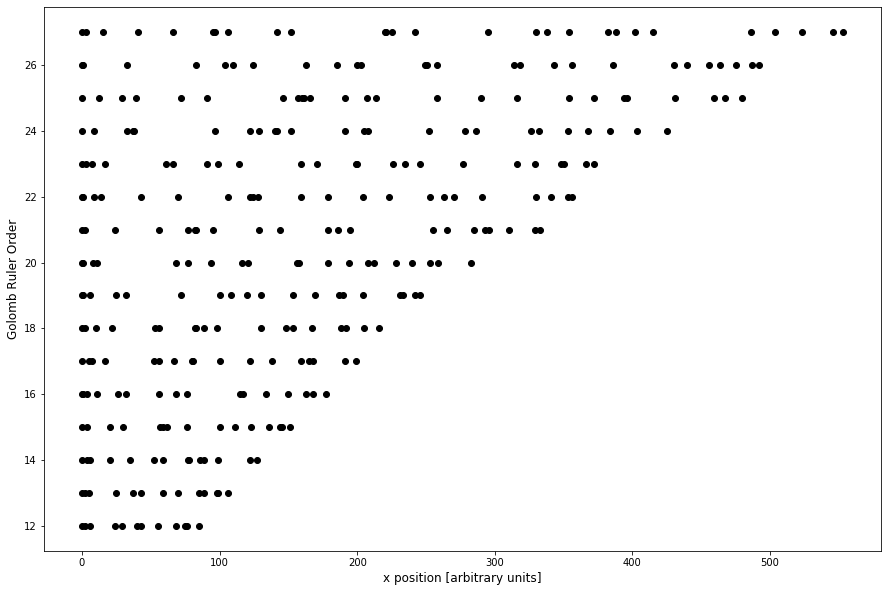

In [4]:
# let's look at the different Golomb rulers
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_xlabel("x position [arbitrary units]", fontsize=12)
ax.set_ylabel("Golomb Ruler Order", fontsize=12)
for order, ruler in golomb_rulers.items():
    for pos in ruler:
        ax.plot(pos, order, color='k', marker='o', lw=0)

In [5]:
NFREQS = 1024
NPIX = 128
NTIMES = 60
freqs = np.linspace(0.06, 0.22, NFREQS) # GHz
jds = np.linspace(2458388.0, 2458388.2, NTIMES)
pix = np.linspace(-1, 1, NPIX) # horizon to horizon; 1D sky

# base separation is 1/50th of the base HERA separation
sep = 14.7 * 100 / aipy.const.len_ns / 50 # ns

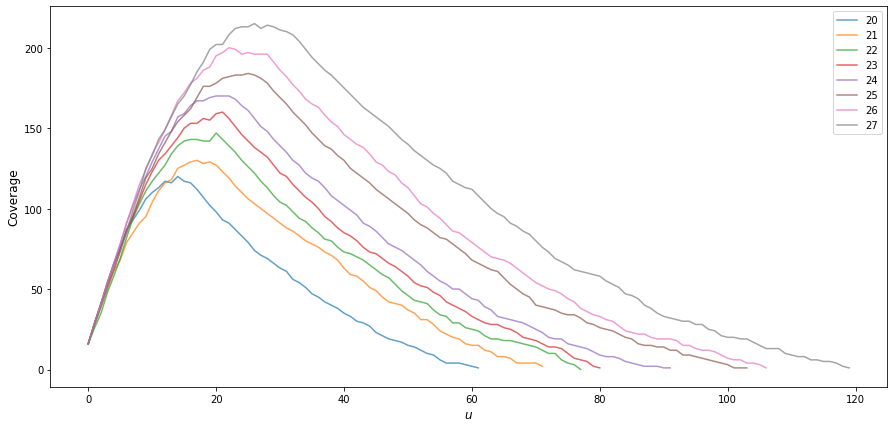

In [9]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$u$", fontsize=12)
ax.set_ylabel("Coverage", fontsize=12)
for order, ruler in golomb_rulers.items():
    if order < 20:
        continue
    antpos = linear_array(ruler, sep)
    u_cov = get_u_coverage(antpos, freqs)
    ax.plot(u_cov, alpha=0.7, label=order)
_ = ax.legend()

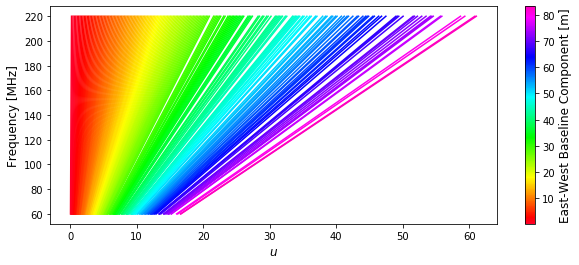

In [34]:
# Show tracks in u-nu plane
antpos = linear_array(golomb_rulers[20], base_sep=sep)
baselines_ns = construct_baselines(antpos)
baselines = {
    antpair: baseline * constants.c.value / 1e9 
    for antpair, baseline in baselines_ns.items()
} # meters
bl_min = min(bl[0] for bl in baselines.values())
bl_max = max(bl[0] for bl in baselines.values())
cmap = plt.cm.gist_rainbow
norm = plt.cm.colors.Normalize(vmin=bl_min, vmax=bl_max)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("Frequency [MHz]", fontsize=12)
for bl_ns, bl in zip(baselines_ns.values(), baselines.values()):
    color = cmap(norm(bl[0]))
    umodes = bl_ns[0] * freqs
    ax.plot(umodes, freqs * 1e3, color=color)
cbar = fig.colorbar(mappable=smap, ax=ax)
cbar.set_label("East-West Baseline Component [m]", fontsize=12)
filename = "/home/bobby/HERA/plots/nucal/baseline_tracks.pdf"
fig.savefig(filename, bbox_inches='tight')
fig.savefig(filename.replace(".pdf", ".png"), bbox_inches='tight')

**Figure ?? |** Visualization of relation between East-West baseline length, frequency, and $u$. Each baseline traces a line in the $u\nu$-plane (though it looks similar, that's a $\nu$ for frequency, not a $v$); as plotted above, the slope of the line is given by $c/\mathbf{b}\cdot\mathbf{\hat{e}}$, with $\mathbf{\hat{e}}$ being the unit vector in the East direction.

Let's take a moment to pause and make sense of the above figure in the context of the eta transform and the delay transform. Both of these integrals are calculated along the frequency axis; however, the delay transform is calculated as a <i>per-baseline</i> quantity, and so it does not follow a vertical line in the $u\nu$-plane. As a result, the delay transform mixes different Fourier modes on the sky, and the degree of mixing increases with increasing baseline length.

In [30]:
intensities = mock_sky_signals(freqs, npix=pix.size)

In [31]:
beams = construct_beam_dict(pix, freqs)

In [56]:
umin = min(bl[0] for bl in baselines_ns.values()) * freqs.min()
umax = max(bl[0] for bl in baselines_ns.values()) * freqs.max()
umodes = np.linspace(umin, umax, 500)
vis_fields = construct_vis_fields(pix, umodes, intensities=intensities, beams=beams)

In [35]:
visibilities = construct_true_visibilities(antpos, pix, freqs, intensities=intensities, beams=beams)

In [37]:
vis_field = vis_fields['SF']
vis_field = np.ma.MaskedArray(data=vis_field, mask=np.isnan(vis_field))

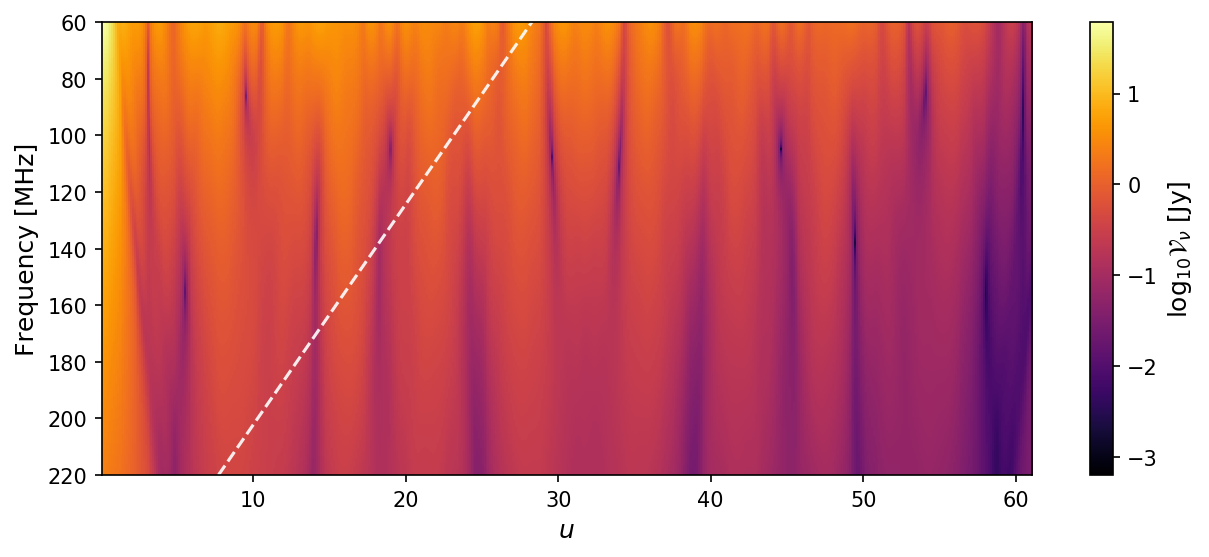

In [74]:
mode = 'log'

fig = plt.figure(figsize=(10,4), dpi=150)
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u$', fontsize=12)
ax.set_ylabel('Frequency [MHz]', fontsize=12)
extent = (umodes.min(), umodes.max(), freqs.max() * 1e3, freqs.min() * 1e3)

if mode == 'log':
    cbar_label = r"$\log_{10}\mathcal{V}_\nu$ [Jy]"
    vmin, vmax = None, None
    cmap = 'inferno'
    data = np.log10(np.abs(vis_field))
elif mode == 'real':
    cbar_label = r"$\mathcal{V}_\nu$ [Jy]"
    vmin, vmax = -200, 200
    cmap = 'inferno'
    data = np.real(vis_field)
elif mode == 'phs':
    cbar_label = "Phase [rad]"
    vmin, vmax = -np.pi, np.pi
    cmap = 'twilight'
    data = np.angle(vis_field)
else:
    cbar_label = None
    vmin, vmax = None, None
    cmap = 'viridis'
    data = vis_field
    
cax = ax.imshow(data, aspect='auto', vmin=vmin, vmax=vmax, 
                extent=extent, cmap=cmap)

cbar = fig.colorbar(cax)
cbar.set_label(cbar_label, fontsize=12)
ax.plot(freqs * baselines_ns[(5,13)][0], freqs[::-1] * 1e3, color='white', ls='--', alpha=0.9)
filename = "/home/bobby/HERA/plots/nucal/vis_field_amps.pdf"
fig.savefig(filename, dpi=150, bbox_inches='tight')
fig.savefig(filename.replace(".pdf", ".png"), dpi=150, bbox_inches='tight')

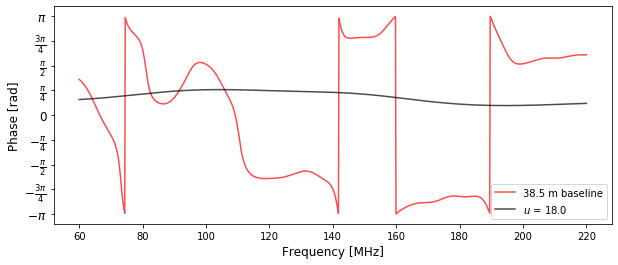

In [108]:
antpair = (5, 13)
baseline = baselines[antpair]
ai, aj = antpair
visibility = visibilities['SF'][:,ai,aj]
vis_phases = np.angle(visibility)
vis_field_phases = np.angle(vis_field)
u_index = np.argmin(np.abs(umodes - np.mean(baselines_ns[antpair][0] * freqs)))
umode = umodes[u_index]
phases = vis_field_phases[:,u_index]

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [MHz]", fontsize=12)
ax.set_ylabel("Phase [rad]", fontsize=12)
yticks = np.linspace(-np.pi, np.pi, 9)
yticklabels = [
    r"$-\pi$", 
    r"$-\frac{3\pi}{4}$", 
    r"$-\frac{\pi}{2}$",
    r"$-\frac{\pi}{4}$",
    "0",
    r"$\frac{\pi}{4}$",
    r"$\frac{\pi}{2}$",
    r"$\frac{3\pi}{4}$",
    r"$\pi$",
]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, fontdict={'fontsize':12})
ax.plot(freqs * 1e3, vis_phases, color='red', alpha=0.7, label=f"{baseline[0]:.1f} m baseline")
ax.plot(freqs * 1e3, phases, color='k', alpha=0.7, label=f"$u$ = {umode:.1f}")
ax.legend(loc='best')
filename = "/home/bobby/HERA/plots/nucal/phase_stability.pdf"
fig.savefig(filename)
fig.savefig(filename.replace(".pdf", ".png"))

**Figure ?? |** Comparison of phase stability for a visibility measurement (red) and a visibility field measurement (orange).

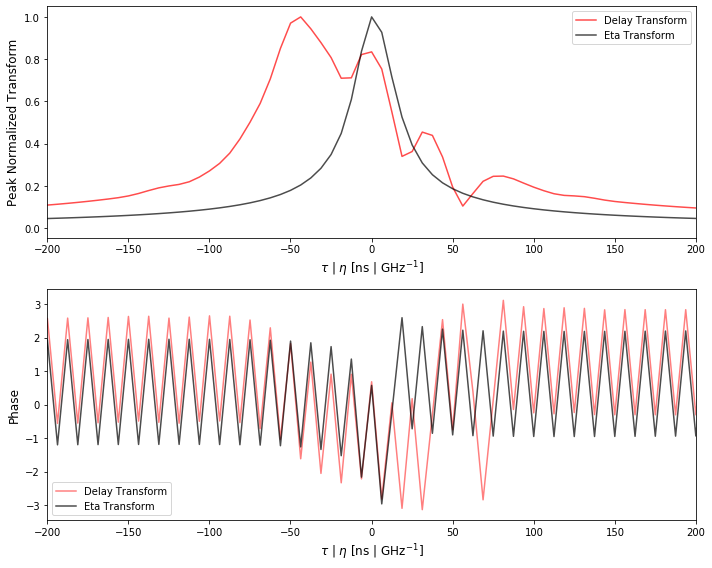

In [112]:
# Compare the eta transform and delay transform
etas = fourier_freqs(freqs)
eta_transform = FFT(np.fft.fftshift(vis_field[:,u_index]), axis=0, taper='blackman-harris')
delay_transform = FFT(np.fft.fftshift(visibility), axis=0, taper='blackman-harris')
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_xlabel(r"$\tau$ | $\eta$ [ns | GHz$^{-1}$]", fontsize=12)
ax1.set_ylabel("Peak Normalized Transform", fontsize=12)
ax2.set_xlabel(r"$\tau$ | $\eta$ [ns | GHz$^{-1}$]", fontsize=12)
ax2.set_ylabel("Phase", fontsize=12)
ax1.set_xlim(-200,200)
ax2.set_xlim(-200,200)
ax1.plot(
    etas, np.abs(delay_transform) / np.abs(delay_transform).max(), 
    color='red', label="Delay Transform", alpha=0.7
)
ax1.plot(
    etas, np.abs(eta_transform) / np.abs(eta_transform).max(),
    color='k', label="Eta Transform", alpha=0.7    
)
ax2.plot(etas, np.angle(delay_transform), color='red', label="Delay Transform", alpha=0.5)
ax2.plot(etas, np.angle(eta_transform), color='k', label="Eta Transform", alpha=0.7)
ax1.legend()
ax2.legend()
fig.tight_layout()
filename = "/home/bobby/HERA/plots/nucal/eta_vs_delay_transform.pdf"
fig.savefig(filename)
fig.savefig(filename.replace(".pdf", ".png"))

**Figure ?? |** Comparison of the delay transform and the eta transform, taken at the mean $u$ measured by the visibility used to compute the delay transform.

In [146]:
# see if we can filter out foregrounds to recover EoR, first with the visibility fields
# then with the pseudo-visibilities
eor_vis_field = vis_fields['SE']
fg_vis_field = vis_fields['SF']
true_vis_field = eor_vis_field + fg_vis_field
filtered_vis_field, info = dayenu_filter(
    x=freqs,
    data=true_vis_field.T,
    wgts=np.ones_like(true_vis_field.T),
    filter_dimensions=[1],
    filter_centers=[0],
    filter_half_widths=[100],
    filter_factors=1e-9,
)
filtered_vis_field = filtered_vis_field.T

In [129]:
freqs_MHz = freqs * 1e3

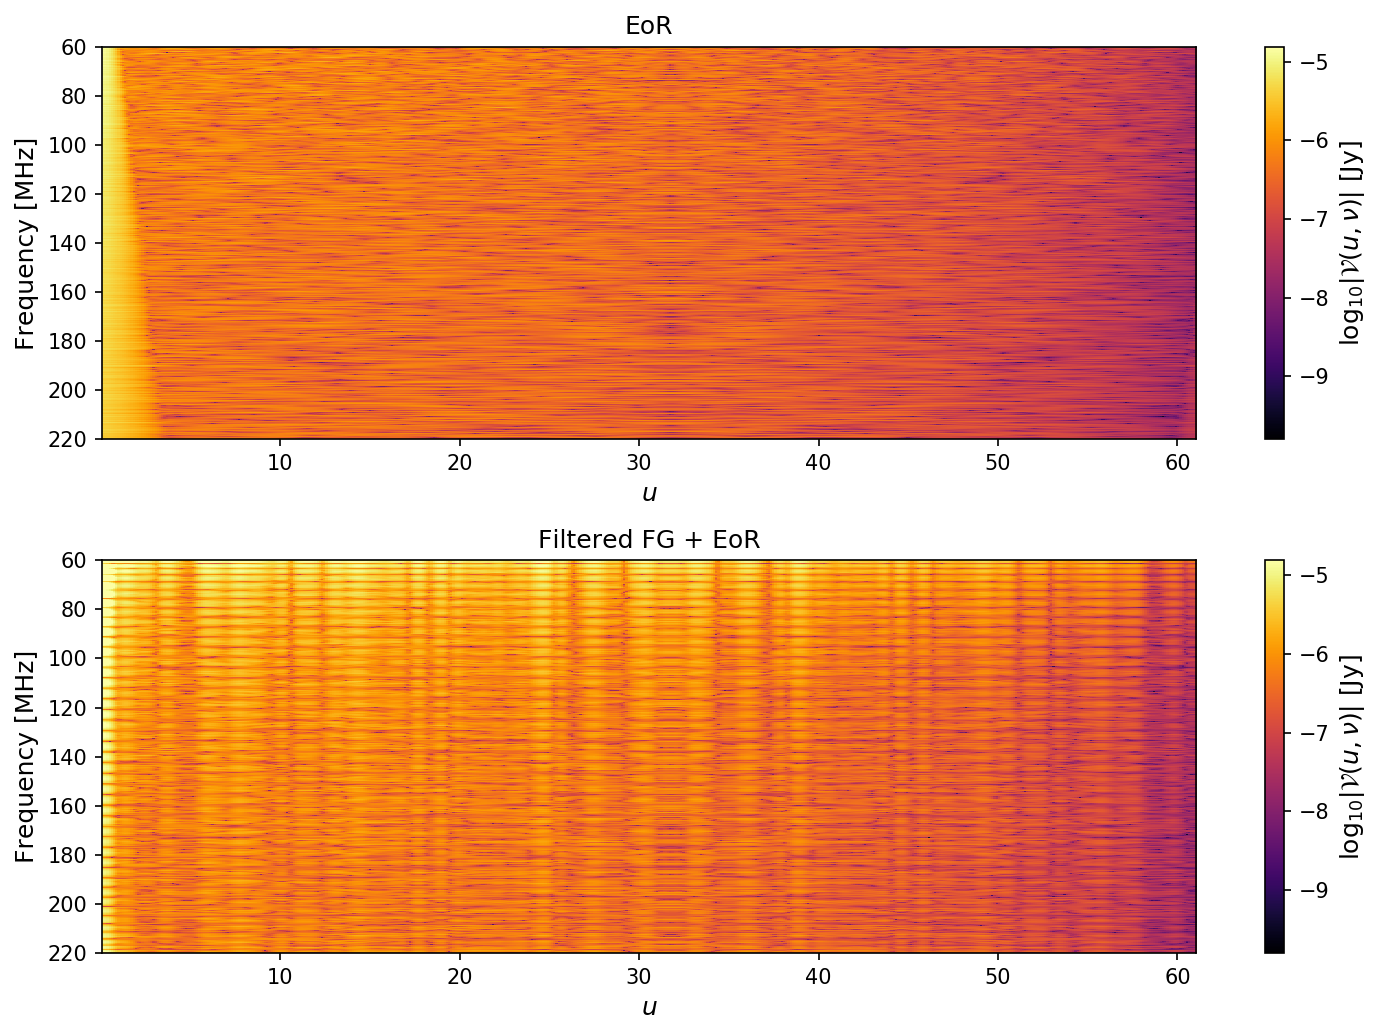

In [161]:
fig = plt.figure(figsize=(10,7), dpi=150)
axes = fig.subplots(2)
extent = (umodes.min(), umodes.max(), freqs_MHz.max(), freqs_MHz.min())
vmin = np.log10(np.abs(eor_vis_field)).min()
vmax = np.log10(np.abs(eor_vis_field)).max()
cmap = plt.cm.inferno
norm = plt.cm.colors.Normalize(vmin=vmin, vmax=vmax)
smap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
for ax, vis in zip(axes[:2], (eor_vis_field, filtered_vis_field)):
    if vis is eor_vis_field:
        ax.set_title("EoR", fontsize=12)
    else:
        ax.set_title("Filtered FG + EoR", fontsize=12)
    ax.set_xlabel(r"$u$", fontsize=12)
    ax.set_ylabel("Frequency [MHz]", fontsize=12)
    ax.imshow(np.log10(np.abs(vis)), aspect='auto', extent=extent, cmap=cmap, norm=norm)
    cbar = fig.colorbar(mappable=smap, ax=ax)
    cbar.set_label(r"$\log_{10}|\mathcal{V}(u,\nu)|$ [Jy]", fontsize=12)


fig.tight_layout()

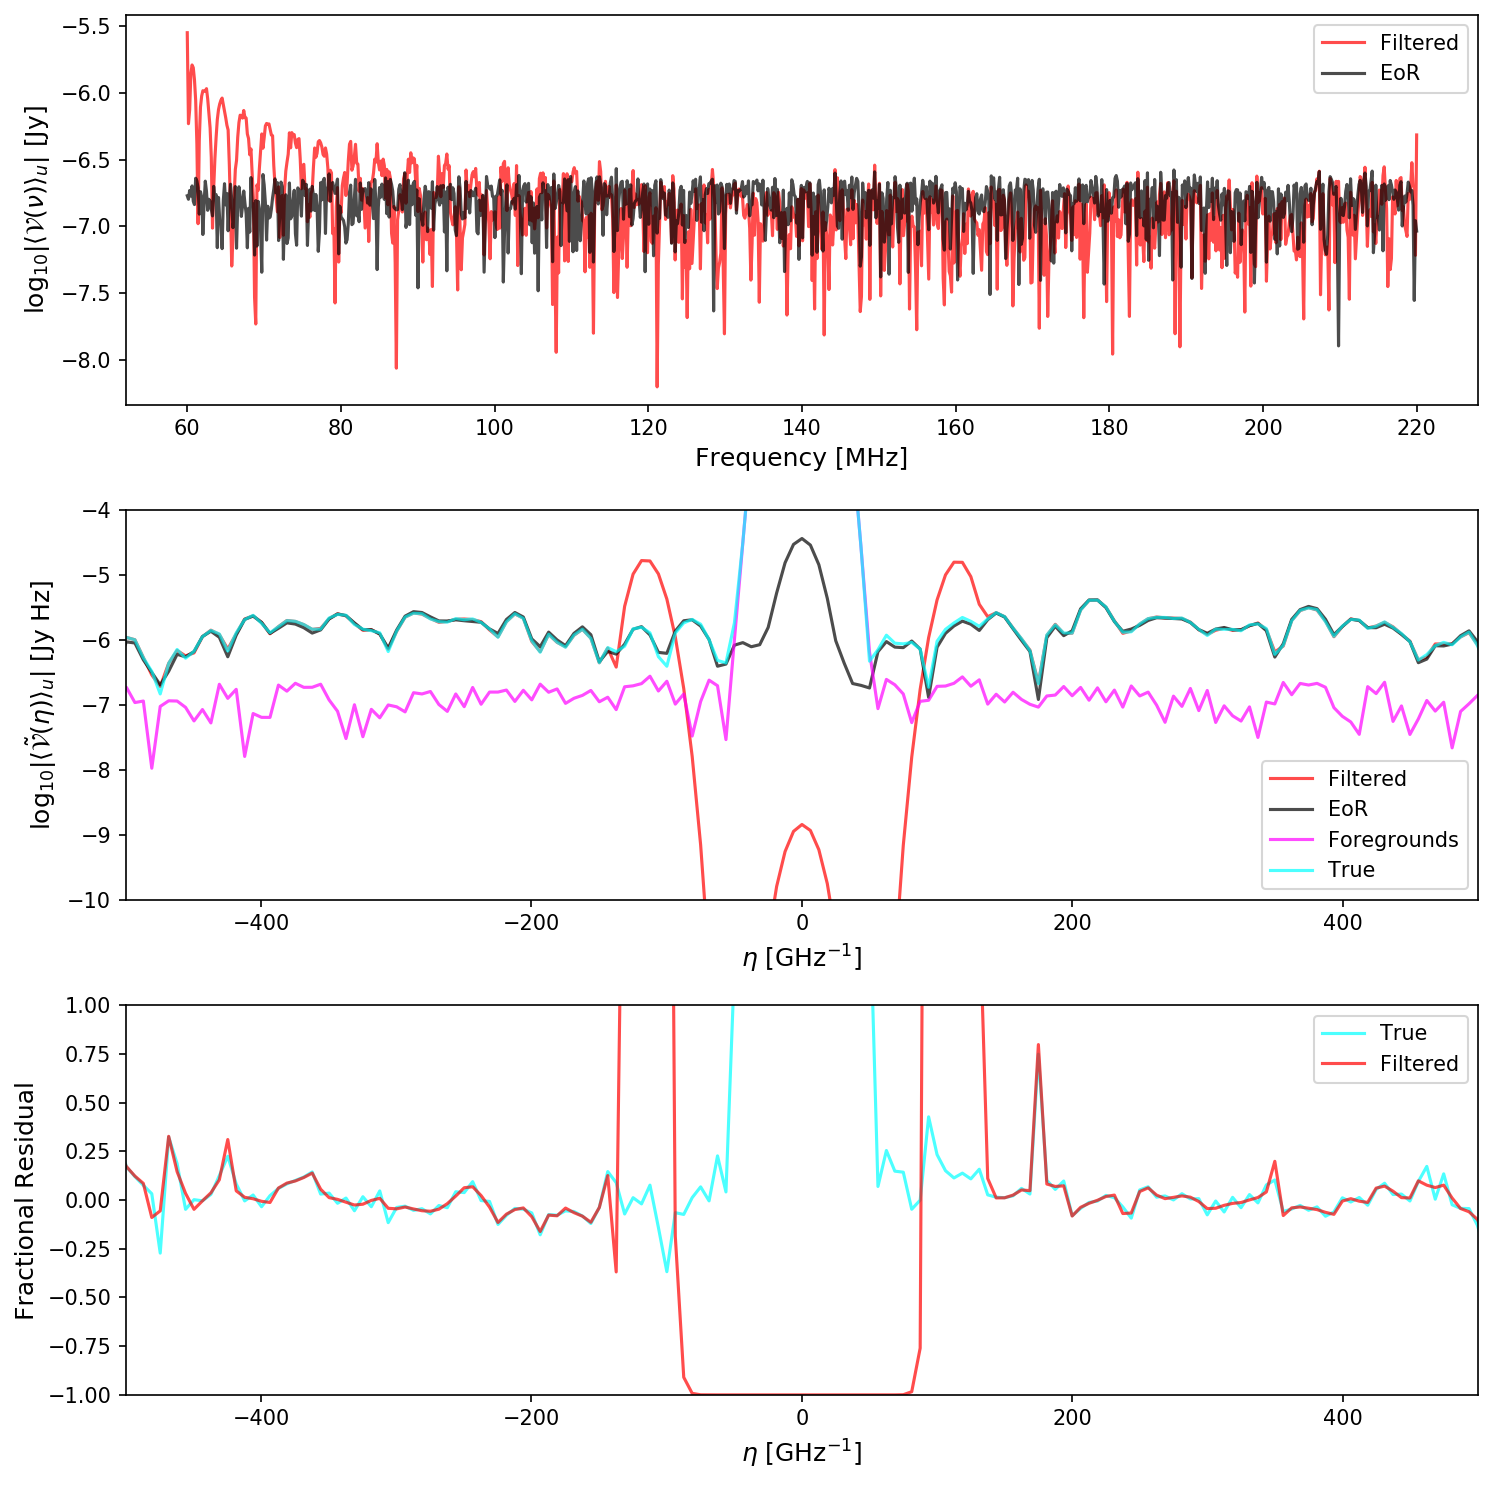

In [166]:
fig = plt.figure(figsize=(10,10), dpi=150)
axes = fig.subplots(3)

# Compare as a function of frequency, averaged over u    
ax = axes[0]
ax.set_xlabel("Frequency [MHz]", fontsize=12)
ax.set_ylabel(r"$\log_{10}|\langle\mathcal{V}(\nu)\rangle_u|$ [Jy]", fontsize=12)
avg_filt_vis_field = np.log10(np.abs(np.mean(filtered_vis_field, axis=1)))
avg_eor_vis_field = np.log10(np.abs(np.mean(eor_vis_field, axis=1)))
ax.plot(freqs_MHz, avg_filt_vis_field, color='red', alpha=0.7, label="Filtered")
ax.plot(freqs_MHz, avg_eor_vis_field, color='k', alpha=0.7, label="EoR")
_ = ax.legend()

# Same as above, but now as a function of eta
ax = axes[1]
ax.set_xlabel(r"$\eta$ [GHz$^{-1}$]", fontsize=12)
ax.set_ylabel(r"$\log_{10}|\langle\tilde{\mathcal{V}}(\eta)\rangle_u|$ [Jy Hz]", fontsize=12)
fft_filt_vis_field = FFT(
    filtered_vis_field, 
    axis=0, 
    taper='bh7',
)
fft_eor_vis_field = FFT(
    eor_vis_field, 
    axis=0, 
    taper='bh7',
)
fft_fg_vis_field = FFT(
    fg_vis_field, 
    axis=0, 
    taper='bh7',
)
fft_true_vis_field = FFT(
    true_vis_field, 
    axis=0, 
    taper='bh7',
)
avg_fft_filt_vis_field = np.log10(np.abs(np.mean(fft_filt_vis_field, axis=1)))
avg_fft_eor_vis_field = np.log10(np.abs(np.mean(fft_eor_vis_field, axis=1)))
avg_fft_fg_vis_field = np.log10(np.abs(np.mean(fft_fg_vis_field, axis=1)))
avg_fft_true_vis_field = np.log10(np.abs(np.mean(fft_true_vis_field, axis=1)))
etas = fourier_freqs(freqs)
eta_cut = 500
ax.plot(etas, avg_fft_filt_vis_field, color='red', alpha=0.7, label="Filtered")
ax.plot(etas, avg_fft_eor_vis_field, color='k', alpha=0.7, label="EoR")
ax.plot(etas, avg_fft_fg_vis_field, color='magenta', alpha=0.7, label="Foregrounds")
ax.plot(etas, avg_fft_true_vis_field, color='cyan', alpha=0.7, label="True")
ax.set_xlim(-eta_cut, eta_cut)
ax.set_ylim(-10, -4)
_ = ax.legend()

# Plot residuals as a function of eta
true_resids = (10**avg_fft_true_vis_field - 10**avg_fft_eor_vis_field) / 10**avg_fft_eor_vis_field
filt_resids = (10**avg_fft_filt_vis_field - 10**avg_fft_eor_vis_field) / 10**avg_fft_eor_vis_field
ax = axes[2]
ax.set_xlabel(r"$\eta$ [GHz$^{-1}$]", fontsize=12)
ax.set_ylabel("Fractional Residual", fontsize=12)
ax.plot(etas, true_resids, color='cyan', alpha=0.7, label="True")
ax.plot(etas, filt_resids, color='red', alpha=0.7, label="Filtered")
ax.set_xlim(-eta_cut, eta_cut)
ax.set_ylim(-1, 1)
_ = ax.legend()
fig.tight_layout()

Conclusion: if we had access to the visibility fields, then we would actually be contaminating our power spectrum estimate by filtering out the foregrounds.  
  
Now, this is a bit of a contrived test&mdash;the foregrounds are very well-behaved in the visibility fields, so we should actually expect to get a very good estimate of the power spectrum once we reach $\eta$-modes where EoR dominates over foregrounds. We will never have true access to the visibility fields, so we really need to test this with the pseudo-visibilities.

In [171]:
visibilities['SF'].shape

(1024, 20, 20)

In [173]:
pseudo_visibilities = construct_interp_vis_dict(
    ant1=0,
    ant2=15,
    antpos=antpos,
    freqs=freqs,
    vis=visibilities,
    cov_thresh=100,
    show_progress=True,
    filter_centers=[0],
    filter_factors=[1e-9],
    filter_dimensions=[0],
    filter_half_widths=[50],
)

0 0.06
0.57 112 0
20 0.06312805474095796
0.5997165200391007 112 3
40 0.06625610948191593
0.6294330400782013 114 8
60 0.0693841642228739
0.6591495601173021 115 12
80 0.07251221896383186
0.6888660801564027 113 14
100 0.07564027370478983
0.7185826001955034 112 16
120 0.0787683284457478
0.748299120234604 109 16
140 0.08189638318670577
0.7780156402737048 106 16


In [194]:
metadata = pseudo_visibilities['metadata']
pseudo_fg_vis = pseudo_visibilities['SF']
pseudo_true_vis = pseudo_visibilities['SFE']
pseudo_eor_vis = pseudo_visibilities['SE']
interp_freqs = metadata["freqs"]
ant1, ant2 = metadata["baseline"]
eor_vis = visibilities['SE'][:,ant1,ant2]

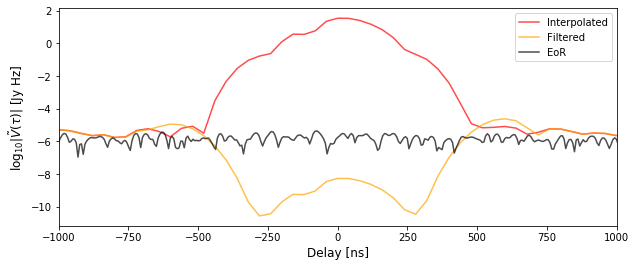

In [392]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("Delay [ns]", fontsize=12)
ax.set_ylabel(r"$\log_{10}|\tilde{V}(\tau)|$ [Jy Hz]", fontsize=12)
dlys = fourier_freqs(np.array(interp_freqs))
fft_pseudo_true_vis = FFT(np.array(pseudo_true_vis), axis=0, taper='bh7')
fft_eor_vis = FFT(eor_vis, axis=0, taper='bh7')
pseudo_filt_vis = dayenu_filter(
    x=interp_freqs,
    data=np.array(pseudo_true_vis),
    wgts=np.ones_like(pseudo_true_vis),
    filter_dimensions=[0],
    filter_centers=[0],
    filter_half_widths=[500],
    filter_factors=[1e-9],
)[0]
fft_pseudo_filt_vis = FFT(pseudo_filt_vis, axis=0, taper='bh7')
all_dlys = fourier_freqs(freqs)
ax.plot(dlys, np.log10(np.abs(fft_pseudo_true_vis)), color='red', alpha=0.7, label="Interpolated")
ax.plot(dlys, np.log10(np.abs(fft_pseudo_filt_vis)), color='orange', alpha=0.7, label="Filtered")
ax.plot(all_dlys, np.log10(np.abs(fft_eor_vis)), color='k', alpha=0.7, label="EoR")
ax.set_xlim(-1000, 1000)
_ = ax.legend()

In [333]:
# This doesn't do what I was hoping it would do.
def construct_pseudo_visibilities(
    visibilities,
    antpos,
    freqs,
    min_Nsamples=200,
    u_resolution=0.1,
):
    """
    Construct pseudo-visibility array from visibilities.
    
    Parameters
    ----------
    visibilities: array-like of complex
        Array of visibility measurements with shape (Nfreqs, Nants, Nants).
    antpos: dict
        Dictionary mapping antenna number to antenna position in ns.
    freqs: array-like of float
        Frequencies at which visibilities are measured, in units of GHz.
    min_Nsamples: int, optional
        Minimum number of samples in any given u-bin. Default is 200.
    u_resolution: float, optional
        Size of each u-bin. Default is 0.1.
        
    Returns
    -------
    pseudo_visibilities: array-like of complex
        Array of pseudo-visibilities with shape set by min_Nsamples and u_resolution.
    """
    # Determine which u-modes to keep.
    baselines = construct_baselines(antpos)
    measured_u_modes = np.concatenate([np.abs(bl[0]) * freqs for bl in baselines.values()])
    u_max = measured_u_modes.max()
    u_bin_edges = np.arange(u_resolution, u_max + u_resolution, u_resolution)
    u_bin_centers = 0.5 * (u_bin_edges[1:] + u_bin_edges[:-1])
    u_coverage = np.histogram(measured_u_modes, bins=u_bin_edges)[0]
    select_u_modes = u_bin_centers[u_coverage >= min_Nsamples]
    
    # Determine which subset of frequencies to keep for the pseudo-visibilities
    freq_min = select_u_modes.max() / max(np.abs(bl[0]) for bl in baselines.values())
    select_freqs = freqs[freqs >= freq_min]
    visibilities = visibilities[freqs >= freq_min, :, :]
    
    # Determine which baselines sample the selected u-modes
    u_mode_to_baseline_map = {np.round(u_mode, 2): [] for u_mode in select_u_modes}
    sampled_u_by_baseline = {
        antpair: np.abs(baseline[0]) * select_freqs
        for antpair, baseline in baselines.items()
    }
    u_bin_edges = np.concatenate([[u_resolution], 0.5 * u_resolution + select_u_modes])
    for antpair, sampled_u_modes in sampled_u_by_baseline.items():
        hist = np.histogram(sampled_u_modes, bins=u_bin_edges)[0]
        keys = select_u_modes[hist.astype(bool)]
        for key in keys:
            u_mode_to_baseline_map[np.round(key,2)].append(antpair)
                
    # Initialize the pseudo-visibility array
    pseudo_visibilities = np.zeros((select_u_modes.size, select_freqs.size), dtype=np.complex)
    nsamples = np.zeros_like(pseudo_visibilities, dtype=int)
    
    # Begin process of filling in pseudo-visibilities
    for i, u_mode in enumerate(select_u_modes):
        baselines_to_use = u_mode_to_baseline_map[np.round(u_mode, 2)]
        Nsamples = len(baselines_to_use)
        for ant1, ant2 in baselines_to_use:
            this_vis = visibilities[:, ant1, ant2]
            sampled_u_modes = sampled_u_by_baseline[(ant1, ant2)]
            key = np.logical_and(
                u_mode - 0.5 * u_resolution < sampled_u_modes,
                sampled_u_modes < u_mode + 0.5 * u_resolution
            )
            pseudo_visibilities[i,key] += visibilities[key,ant1,ant2]
            nsamples[i,key] += 1
        
    pseudo_visibilities /= np.where(nsamples == 0, 1, nsamples)
    return pseudo_visibilities, select_u_modes, select_freqs

In [334]:
true_vis = visibilities['SF'] + visibilities['SE']
pseudo_visibilities, select_u_modes, select_freqs = construct_pseudo_visibilities(true_vis, antpos, freqs)

In [341]:
smoothed_pseudo_vis, info = dayenu_filter(
    x=select_freqs,
    data=pseudo_visibilities,
    wgts=np.ones_like(pseudo_visibilities),
    filter_dimensions=[1],
    filter_centers=[0],
    filter_half_widths=[1/(2*np.mean(np.diff(select_freqs)))],
    filter_factors=[1],
)

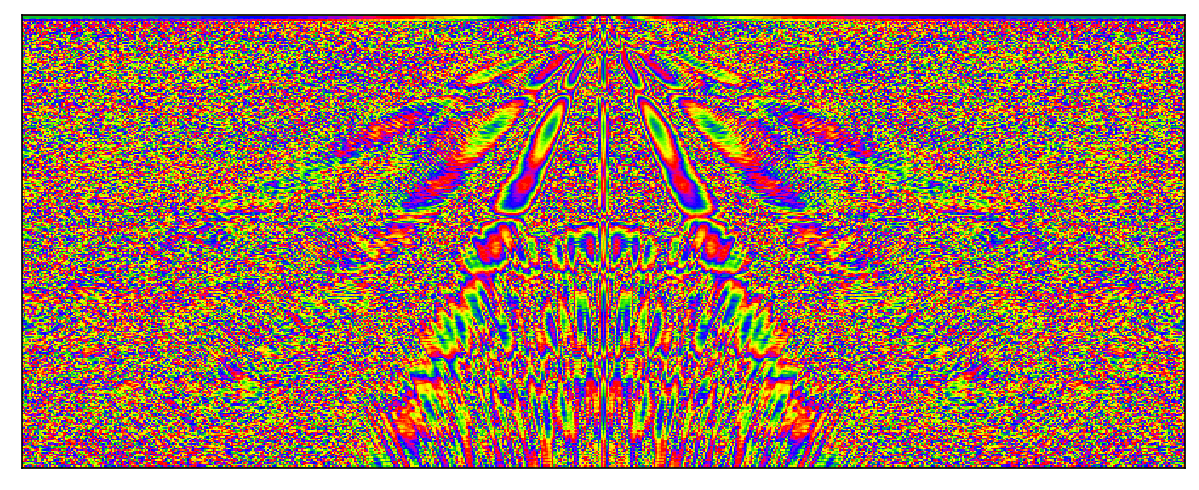

In [380]:
fig = plt.figure(figsize=(10,4), dpi=150)
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
cmap = 'prism'
ax.imshow(
    np.log10(np.abs(FFT(smoothed_pseudo_vis, axis=1, taper='bh7'))),
    aspect='auto',
    cmap=cmap,
)
filename = f"/home/bobby/HERA/plots/cool_plots/trippy_pseudo_vis_fft_{cmap}.pdf"
fig.savefig(filename, dpi=150)
fig.savefig(filename.replace(".pdf", ".png"), dpi=150)

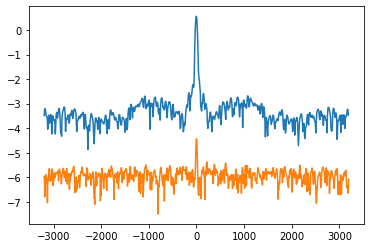

In [344]:
plt.plot(
    fourier_freqs(select_freqs),
    np.log10(np.abs(np.mean(FFT(smoothed_pseudo_vis, axis=1, taper='bh7'), axis=0)))
)
plt.plot(etas, avg_fft_eor_vis_field)

In [381]:
# Try to independently develop the construction of pseudo-visibilities via interpolation.
def construct_interpolated_pseudo_visibility():
    pass

# Moving Toward NuCal

## Motivation
Let's begin by recalling the Radio Interferometry Measurement Equation (RIME):
$$
V(\nu,\vec{b}) = \int A_\nu(\Omega)I_\nu(\Omega)\mathrm{e}^{-i2\pi\nu\vec{b}\cdot\hat{n}/c}\mathrm{d\Omega},
$$
where $A_\nu(\Omega)$ is the frequency- and direction-dependent primary beam response of an antenna, $I_\nu(\Omega)$ is the specific intensity on the sky, $\vec{b}$ is the baseline used to measure the visibility, and $\hat{n}$ is the direction toward the patch of sky $\Omega$. Now consider a pair of frequencies and baselines such that $\vec{u} = \nu_1\vec{b}_1 = \nu_2\vec{b}_2$. If *both* $A_{\nu_1} \approx A_{\nu_2}$ and $I_{\nu_1} \approx I_{\nu_2}$, then we have $V(\nu_1,\vec{b}_1) \approx V(\nu_2,\vec{b}_2)$. In other words, if two baselines $\vec{b}_1$ and $\vec{b}_2$ measure the same $\vec{u}$ at nearby frequencies $\nu_1$ and $\nu_2$, and if the primary beam and sky do not change much between $\nu_1$ and $\nu_2$, then we should expect the visibilities measured by those baselines at that particular pair of frequencies to be very nearly identical. This is the motivation behind designing *NuCal*.

## Original Suggested Formulation
Let's make some assumptions about the beam response and sky intensity and see where that takes us. As a first approach, let's assume that each of these are separable functions of frequency and solid angle:
$$
\begin{aligned}
A_\nu(\Omega) &= G(\nu)A_0(\Omega) \\
I_\nu(\Omega) &= S(\nu)I_0(\Omega).
\end{aligned}
$$
This allows us to rewrite the RIME as
$$
V(\nu,\vec{b}) = G(\nu)S(\nu)\int A_0(\Omega)I_0(\Omega)\mathrm{e}^{-i2\pi\nu\vec{b}\cdot\hat{n}/c}\mathrm{d\Omega}.
$$
Making the substitution $\vec{u} = \nu\vec{b}$, we can write this as
$$
V(\nu,\vec{b}) = G(\nu)S(\nu)V_0(\vec{u}).
$$
From here, we can construct a system of equations
$$
V(\nu_i,\vec{b}_i) = G(\nu_i)S(\nu_i)V_0(\vec{u}),
$$
subject to the constraint $\nu_i\vec{b}_i = \vec{u}$. Since we can't really separate $G(\nu)S(\nu)$, it may be helpful to make the substitution $G(\nu)S(\nu) = \beta(\nu)$. Now, for a given $u$-mode, we have $N$ equations with $N+1$ unknown variables... so, within a system, we are under-constrained. I suspect that we can break the degeneracy by enforcing that $\beta({\nu})$ has the same value between solutions when measured at the same frequency, but this deserves closer inspection.

## RedCal-Inspired Formulation

One glaring issue from the above formulation is that the solutions $\beta({\nu})$ are obtained on a *per-baseline* basis, so there would be an extra step involved in order to propagate the solutions to per-antenna quantities. This makes me feel a little uneasy, since I haven't done the counting to ensure that we have enough measurements to fully constrain the system down to per-antenna, per-frequency solutions (I suspect that there is a subset of HERA that provides sufficient information to get the desired solutions, but this type of counting problem seems *hard*). Now, to be honest, this alternate formulation faces the same issue: do we have enough measurements? That said, I think this looks a bit nicer, and it's more obvious that the end-goal is antenna-based, per-frequency solutions.  
  
So, the system of equations to solve here looks very similar to the system of equations used in redundant calibration, though is subtly different:
$$
V^{measured}_{ij\nu} = g_{i\nu}g^*_{j\nu}V^{true}_\vec{u}.
$$
I would think that the process for solving this begins by first grouping measurements by the $u$-mode probed; in fact, I suspect that we may be able to remove the issue of directionality by noting that a rotation in $\vec{u}$ should (according to the RIME) just result in an overall phase added to the measured visibility:
$$
V^{measured}_{ij\nu} = g_{i\nu}g^*_{j\nu}\mathrm{e}^{i\phi_{ij}}V^{true}_u.
$$
So instead of grouping by *vectorial* $u$-modes, we would instead group all measurements with identical (up to some tolerance) *magnitude* of $u$-mode probed. In fact, in the end we may end up wanting to bundle the two formulations together&mdash;the formulation in the previous section can provide information about how the sky and beam change, whereas the formulation in this section should provide information about the bandpass gains. Thinking about it, it may be the case that neither formulation is sufficient on its own, nor does it capture everything going on. Following that line of though, perhaps the correct system of equations to solve is actually:
$$
V^{measured}_{ab\nu} = \beta_\nu g_{a\nu}g^*_{b\nu}\mathrm{e}^{i\phi_{ab}}V^{true}_u.
$$
To be honest, I'm not sure how to correctly approach the problem&mdash;but the point of research is to figure that out, right?

# Old code; may revisit later

In [24]:
def cycle_colors(ax):
    for i in range(9): ax._get_lines.get_next_color()

In [25]:
antpos = linear_array(golomb_rulers[27], sep)
#antpos = hera_sim.antpos.linear_array(10)
#antpos = {ant : pos / constants.c.value * 1e9 for ant, pos in antpos.items()}
#antpos = hera_sim.antpos.hex_array(5, split_core=False, outriggers=0)
#antpos = {ant : pos / constants.c.value * 1e9 for ant, pos in antpos.items()}
true_vis = construct_true_visibilities(antpos, pix, freqs, sky_kwargs={"eor_amp" : 1e-4})

In [26]:
baselines = construct_baselines(antpos)

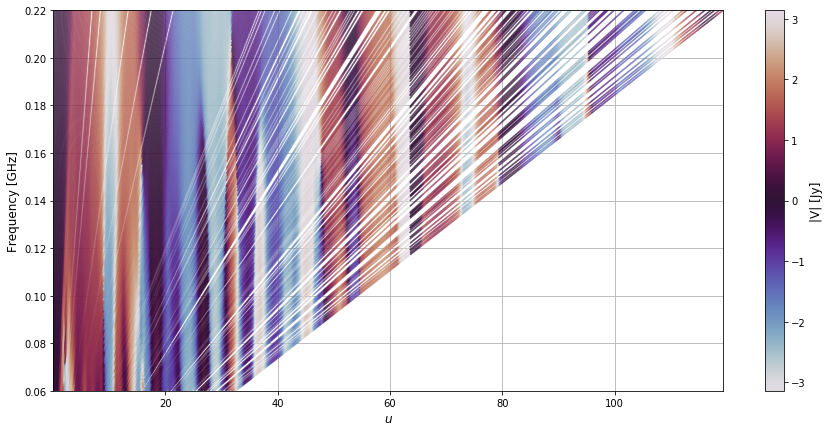

In [27]:
# plot all the visibilities measured by the array

# start by setting up the figure
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_xlabel("$u$", fontsize=12)
ax.set_ylabel("Frequency [GHz]", fontsize=12)
#ax.set_title("Visibility Amplitudes per Baseline", fontsize=12)

# set the axes limits; need to be a little careful with ulims
uvals = [convert_nu_to_u(freqs, bl) for bl in baselines.values()]
uvals = np.asarray(uvals)
ax.set_xlim(uvals.min(), uvals.max())
ax.set_ylim(freqs.min(), freqs.max())
#ax.set_xlim(10,30)
#ax.set_ylim(0.13, 0.17)

# set up stuff for the colorbar
#vis_amplitudes = true_vis['SF'].real
vis_amplitudes = np.angle(true_vis['SF'])
vis_amplitudes[np.isnan(vis_amplitudes)] = 0
#vis_amplitudes = np.ma.MaskedArray(data=vis_amplitudes, mask=vis_amplitudes==0)
vmin, vmax = -np.pi, np.pi
#vmin, vmax = -200, 200
#vmin, vmax = vis_amplitudes[vis_amplitudes != 0].min(), vis_amplitudes.max()
#vis_amplitudes = np.where(vis_amplitudes > 0, vis_amplitudes, vmin)
#norm = colors.LogNorm(vmin, vmax, clip=True)
norm = colors.Normalize(vmin, vmax, clip=True)
#cmap = plt.cm.magma
cmap = plt.cm.twilight
smap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# iterate over all baselines and plot a line for each one
for antpair, baseline in baselines.items():
    ai, aj = antpair
    umodes = convert_nu_to_u(freqs, baseline)
    use_vis = vis_amplitudes[:,ai,aj]
    
    # if we have N umodes, then we'll need N-1 line segments to stitch together
    # each segment needs to be 2x2 (start/end points for u and nu)
    points = np.array([umodes, freqs]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # now we can make the LineCollection object and plot it
    lc = LineCollection(segments, norm=norm, cmap=cmap)
    lc.set_array(use_vis)
    line = ax.add_collection(lc)
    
    # plot the points actually sampled by the array
    # too fine of sampling -> just black lines
    #ax.plot(umodes[::50], freqs[::50], color='k', alpha=0.7, ms=5, lw=0, marker='+')

#bl_lengths = set([np.linalg.norm(bl) for bl in baselines.values()])
#bl_lengths = sorted(list(bl_lengths))
#umodes = convert_nu_to_u(freqs, bl_lengths[-1])
#u0, u1 = umodes[0], umodes[-50]
#fq0, fq1 = freqs[0], freqs[-50]
#du = u1 - u0
#df = fq1 - fq0
#tail_width = 0.0001
#head_width = tail_width * 25
#head_length = head_width * 500
#arrow_params = {"head_width" : head_width, "head_length" : head_length, "width" : tail_width}
#_ = ax.arrow(u0 + 2, fq0, du, df, **arrow_params)
#_ = ax.text(u0 + 5 + du/2, fq0 + df/2, "Delay Transform", rotation=30, fontsize=12)
#_ = ax.arrow(u0 + 2, fq0, 0, df, width=tail_width, head_length=0.005, head_width=1)
#_ = ax.text(u0, fq0 + 1.2 * df/2, r"$\eta$ Transform", rotation=90, fontsize=12)

# add a colorbar
cbar = fig.colorbar(smap)
cbar.set_label("|V| [Jy]", fontsize=12)
#save_path = os.path.join(plot_dir, "dense_u_sampling.pdf")
#fig.savefig(save_path)
#fig.savefig(save_path.replace(".pdf", ".png"))
ax.grid()

In [28]:
antpair = (16,8)
filter_kwargs = {
    'filter_dimensions' : [1],
    'filter_centers' : [0],
    'filter_half_widths' : [40],
    'filter_factors' : [1e-9]
}
interp_vis = construct_interp_vis_dict(
    *antpair, antpos, freqs, true_vis, umin=27, umax=44, **filter_kwargs
)

In [36]:
get_good_channels?

In [42]:
antpos

{0: array([0., 0., 0.]),
 1: array([2.94203532, 0.        , 0.        ]),
 2: array([14.7101766,  0.       ,  0.       ]),
 3: array([40.20781604,  0.        ,  0.        ]),
 4: array([64.72477703,  0.        ,  0.        ]),
 5: array([93.16445179,  0.        ,  0.        ]),
 6: array([95.12580867,  0.        ,  0.        ]),
 7: array([103.95191463,   0.        ,   0.        ]),
 8: array([139.25633846,   0.        ,   0.        ]),
 9: array([149.06312286,   0.        ,   0.        ]),
 10: array([215.74925677,   0.        ,   0.        ]),
 11: array([216.72993521,   0.        ,   0.        ]),
 12: array([220.65264897,   0.        ,   0.        ]),
 13: array([237.32418245,   0.        ,   0.        ]),
 14: array([289.30013977,   0.        ,   0.        ]),
 15: array([323.62388516,   0.        ,   0.        ]),
 16: array([331.46931268,   0.        ,   0.        ]),
 17: array([347.16016772,   0.        ,   0.        ]),
 18: array([374.61916404,   0.        ,   0.        ]),


In [52]:
# for a small range of u-modes, let's see what the delay transform looks
# like for each u, using the visibilities calculated as above

umin, umax = 27, 44
ai, aj = 3, 15
bl = antpos[aj] - antpos[ai]
baselines = construct_baselines(antpos)
afreqs = get_good_channels(bl, freqs, umin, umax, True)
bm_fg = 'SF' # just look at the foregrounds for now
vis_dspec_by_u = {}
vis_dlys_by_u = {}
filter_kwargs = {
    'filter_dimensions' : [1],
    'filter_centers' : [0],
    'filter_half_widths' : [40],
    'filter_factors' : [1e-9]
}
for count, freq in enumerate(afreqs):
    temp_vis = {}
    u = freq * bl[0]
    if count % 20 == 0:
        continue
        print("%.2f done" % (count / len(afreqs)))
    for antpair, baseline in baselines.items():
        ai_, aj_ = antpair
        blx, bly, blz = baseline
        fq = u / blx
        if fq < freqs[0] or fq > freqs[-1]:
            # handle edge cases, where we actually have access to the frequency
            # but rounding errors make the computer think that we don't have access
            if np.isclose(fq, freqs[0]):
                fq = freqs[0]
            elif np.isclose(fq, freqs[-1]):
                fq = freqs[-1]
            else:
                # we don't have access to the requisite frequencies
                continue
        data = true_vis[bm_fg][:, ai_, aj_]
        data += true_vis["SE"][:, ai_, aj_]
        interp_vis = interp1d(freqs, data, kind='cubic', assume_sorted=True)(fq)
        temp_vis[fq] = interp_vis
    interp_fqs = np.asarray(sorted(list(temp_vis.keys())))
    taper = gen_window('blackman-harris', interp_fqs.size)
    _vis = np.asarray([temp_vis[fq] for fq in interp_fqs])
    # take _vis, filter out foregrounds with dayenu filter
    # then DFT that visibility
    dlys = fourier_freqs(interp_fqs)
    vis_dspec_by_u[u] = FFT(_vis * taper, 0)
    vis_dlys_by_u[u] = dlys

In [53]:
# make colormaps
bl_lengths = np.asarray([np.linalg.norm(bl) for bl in baselines.values()])
u_coverage = np.asarray(get_u_coverage(antpos, freqs))
u_coverage_ = u_coverage[umin:umax+1]
u_coverage_interp = interp1d(np.arange(u_coverage.size), u_coverage, kind='linear', assume_sorted=True)

bl_norm = plt.cm.colors.Normalize(vmin=bl_lengths.min(), vmax=bl_lengths.max())
u_cov_norm = plt.cm.colors.Normalize(vmin=u_coverage_.min(), vmax=u_coverage_.max())
u_norm = plt.cm.colors.Normalize(vmin=umin, vmax=umax)
phs_norm = plt.cm.colors.Normalize(vmin=0, vmax=2*np.pi)

bl_map = plt.cm.ScalarMappable(norm=bl_norm, cmap='magma')
u_cov_map = plt.cm.ScalarMappable(norm=u_cov_norm, cmap='magma')
u_map = plt.cm.ScalarMappable(norm=u_norm, cmap='magma')
phs_map = plt.cm.ScalarMappable(norm=phs_norm, cmap='twilight')

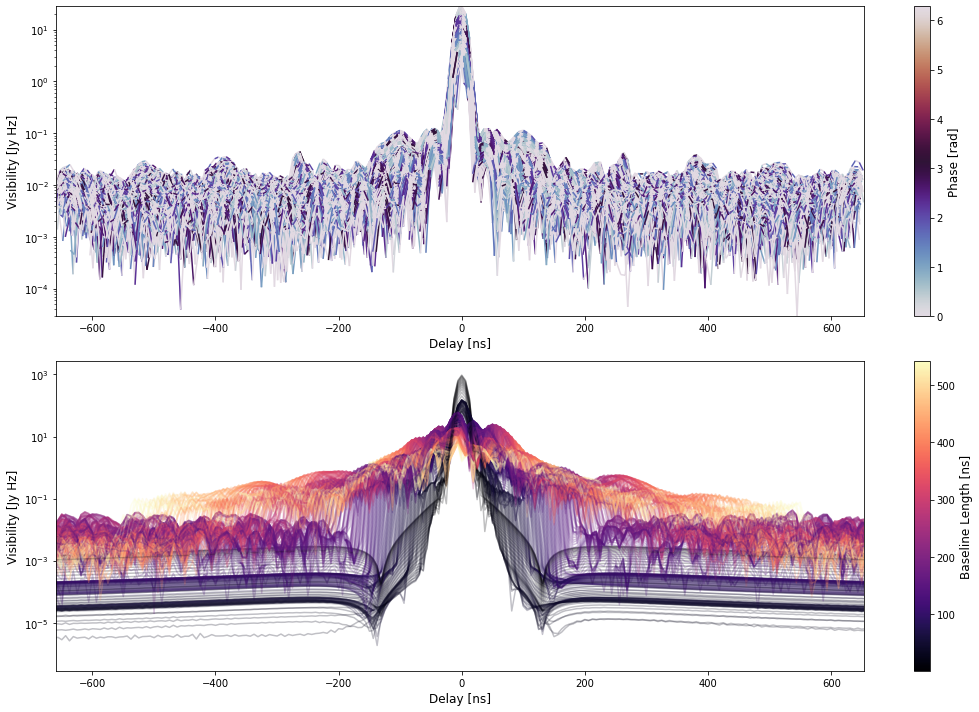

In [54]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
vis_bounds = [
    (np.abs(vis_dspec).min(), np.abs(vis_dspec).max()) 
    for vis_dspec in vis_dspec_by_u.values()
]
vis_min = np.min([v[0] for v in vis_bounds])
vis_max = np.max([v[1] for v in vis_bounds])
all_dlys = np.unique(np.hstack([dlys for dlys in vis_dlys_by_u.values()]))
dly_min, dly_max = np.min(all_dlys), np.max(all_dlys)
ax1.set_ylim(vis_min, vis_max)
ax1.set_yscale('log')

for ax in (ax1, ax2):
    ax.set_xlim(dly_min, dly_max)
    ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel("Visibility [Jy Hz]", fontsize=12)
for u, vis_dspec in vis_dspec_by_u.items():
    dlys = vis_dlys_by_u[u]
    points = np.array([dlys, np.abs(vis_dspec)]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, norm=phs_norm, cmap="twilight")
    lc.set_array(np.angle(vis_dspec))
    _ = ax1.add_collection(lc)
    
taper = gen_window('blackman-harris', freqs.size)
vis_dspec = FFT(copy.deepcopy(true_vis[bm_fg]) * taper[:, None, None], 0)
dlys = fourier_freqs(freqs)
for antpair, baseline in baselines.items():
    ai_, aj_ = antpair
    bl_len = np.linalg.norm(baseline)
    color = plt.cm.magma(bl_norm(bl_len))
    ax2.semilogy(dlys, np.abs(vis_dspec[:, ai_, aj_]), color=color[:3], alpha=0.25)
    
cbar1 = fig.colorbar(mappable=phs_map, ax=ax1)
cbar1.set_label("Phase [rad]", fontsize=12)
cbar2 = fig.colorbar(mappable=bl_map, ax=ax2)
cbar2.set_label("Baseline Length [ns]", fontsize=12)
fig.tight_layout()

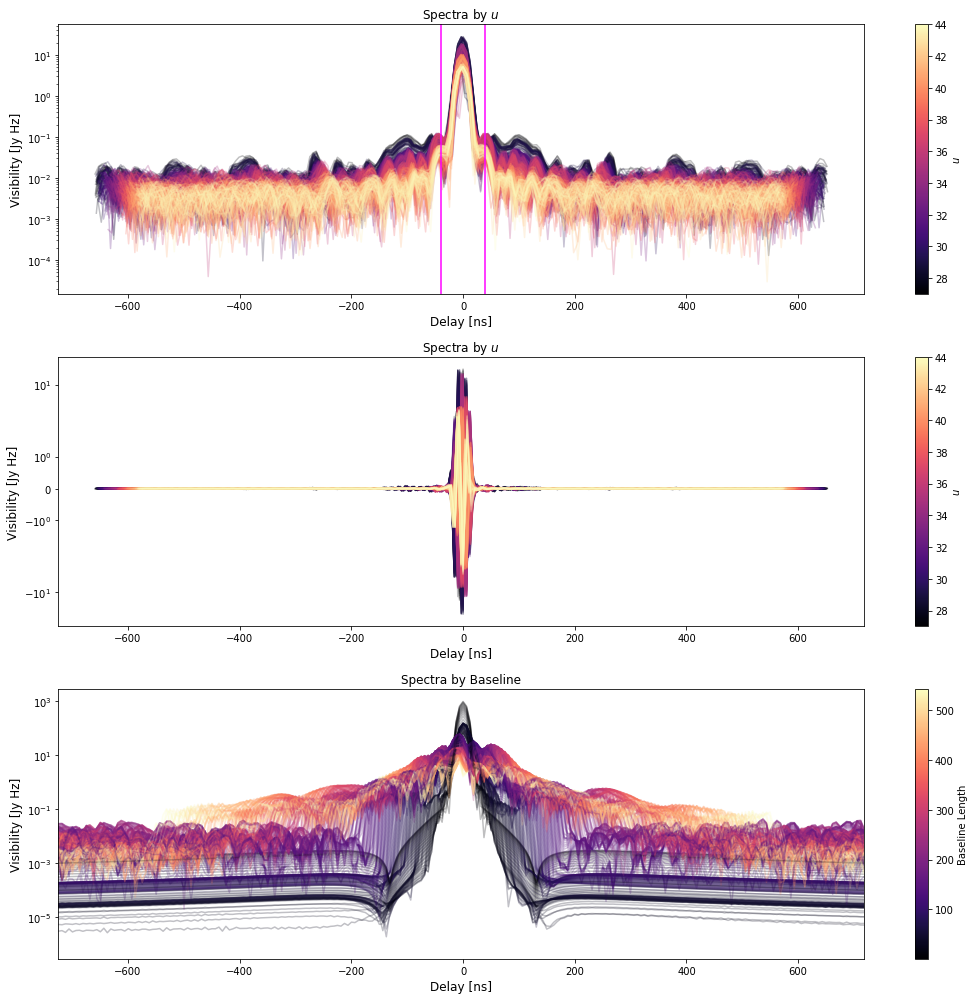

In [55]:
color_by_phase = False
phs_counter = 0
color_by_u = True
color_by_u_cov = False

fig = plt.figure(figsize=(15,14))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set_title("Spectra by $u$", fontsize=12)
ax2.set_title("Spectra by $u$", fontsize=12)
ax3.set_title("Spectra by Baseline", fontsize=12)
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel("Visibility [Jy Hz]", fontsize=12)
for u, vis_dspec in vis_dspec_by_u.items():
    dlys = vis_dlys_by_u[u]
    
    if color_by_u_cov:
        u_cov = u_coverage_interp(u)
        color = plt.cm.magma(u_cov_norm(u_cov))
        use_mappable = u_cov_map
        cbar_label = "$u$ Coverage"
    elif color_by_u:
        color = plt.cm.magma(u_norm(u))
        cbar_label = "$u$"
        use_mappable = u_map
    
    ax1.semilogy(dlys, np.abs(vis_dspec), color=color[:3], alpha=0.25)
    ax2.plot(dlys, np.real(vis_dspec), color=color[:3], alpha=0.25)
    ax2.set_yscale('symlog')
    
ax3.set_xlim(ax1.get_xlim())
taper = gen_window('blackman-harris', freqs.size)
vis_dspec = FFT(copy.deepcopy(true_vis[bm_fg]) * taper[:, None, None], 0)
dlys = fourier_freqs(freqs)
for antpair, baseline in baselines.items():
    ai_, aj_ = antpair
    bl_len = np.linalg.norm(baseline)
    color = plt.cm.magma(bl_norm(bl_len))
    ax3.semilogy(dlys, np.abs(vis_dspec[:, ai_, aj_]), color=color[:3], alpha=0.25)
    
_ = fig.colorbar(mappable=use_mappable, ax=ax1, label=cbar_label)
_ = fig.colorbar(mappable=use_mappable, ax=ax2, label=cbar_label)
_ = fig.colorbar(mappable=bl_map, ax=ax3, label='Baseline Length')
fig.tight_layout()
save_path = '/home/bobby/HERA/Papers/Wedge_Elimination/true_los_transform_with_eor_mod_fg.pdf'
dly = 40
for dly_ in (-dly, dly):
    ax1.axvline(dly_, color='magenta')
#fig.savefig(save_path)
#fig.savefig(save_path.replace('.pdf', '.png'))

In [56]:
# make the top plot using a DFT instead of a FFT
# maybe can do this using the dft_operator and fit_basis_1d functions from uvtools.dspec?

In [57]:
# choose some baseline
antpair = (16,8)
interp_vis_by_u_cov = {}
filter_kwargs = {
    'filter_dimensions' : [1],
    'filter_centers' : [0],
    'filter_half_widths' : [40],
    'filter_factors' : [1e-9]
}
#u_coverage_thresholds = (25, 50, 75, 100, 125, 150, 175, 200)
u_coverage_thresholds = (125, 150, 175, 200)

for u_cov in u_coverage_thresholds:
    print("Constructing interpolated visibilities for a minimum " \
          "u-coverage of %d" % u_cov)
    interp_vis_by_u_cov[u_cov] = construct_interp_vis_dict(
        *antpair, antpos, freqs, true_vis, cov_thresh=u_cov,
        show_progress=True, **filter_kwargs
    )

Constructing interpolated visibilities for a minimum u-coverage of 125
0 0.06
1.6800000000000035 135 0
20 0.06312805474095796
1.767585532746827 139 7
40 0.06625610948191593
1.8551710654936502 142 13
60 0.0693841642228739
1.9427565982404735 148 21
80 0.07251221896383186
2.0303421309872967 154 29
100 0.07564027370478983
2.11792766373412 158 36
120 0.0787683284457478
2.2055131964809433 160 41
140 0.08189638318670577
2.2930987292277663 167 50
160 0.08502443792766373
2.38068426197459 167 53
180 0.0881524926686217
2.4682697947214134 172 61
200 0.09128054740957967
2.5558553274682363 179 70
220 0.09440860215053763
2.6434408602150596 181 75
240 0.0975366568914956
2.731026392961883 185 81
260 0.10066471163245357
2.8186119257087063 190 89
280 0.10379276637341153
2.9061974584555292 195 97
300 0.1069208211143695
2.9937829912023526 196 101
320 0.11004887585532747
3.081368523949176 196 104
340 0.11317693059628543
3.1689540566959993 198 107
360 0.1163049853372434
3.256539589442822 199 111
380 0.119433

4.579081133919854 206 160
400 0.16666666666666666
4.666666666666677 205 162
420 0.16979472140762464
4.7542521994135 205 165


/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_

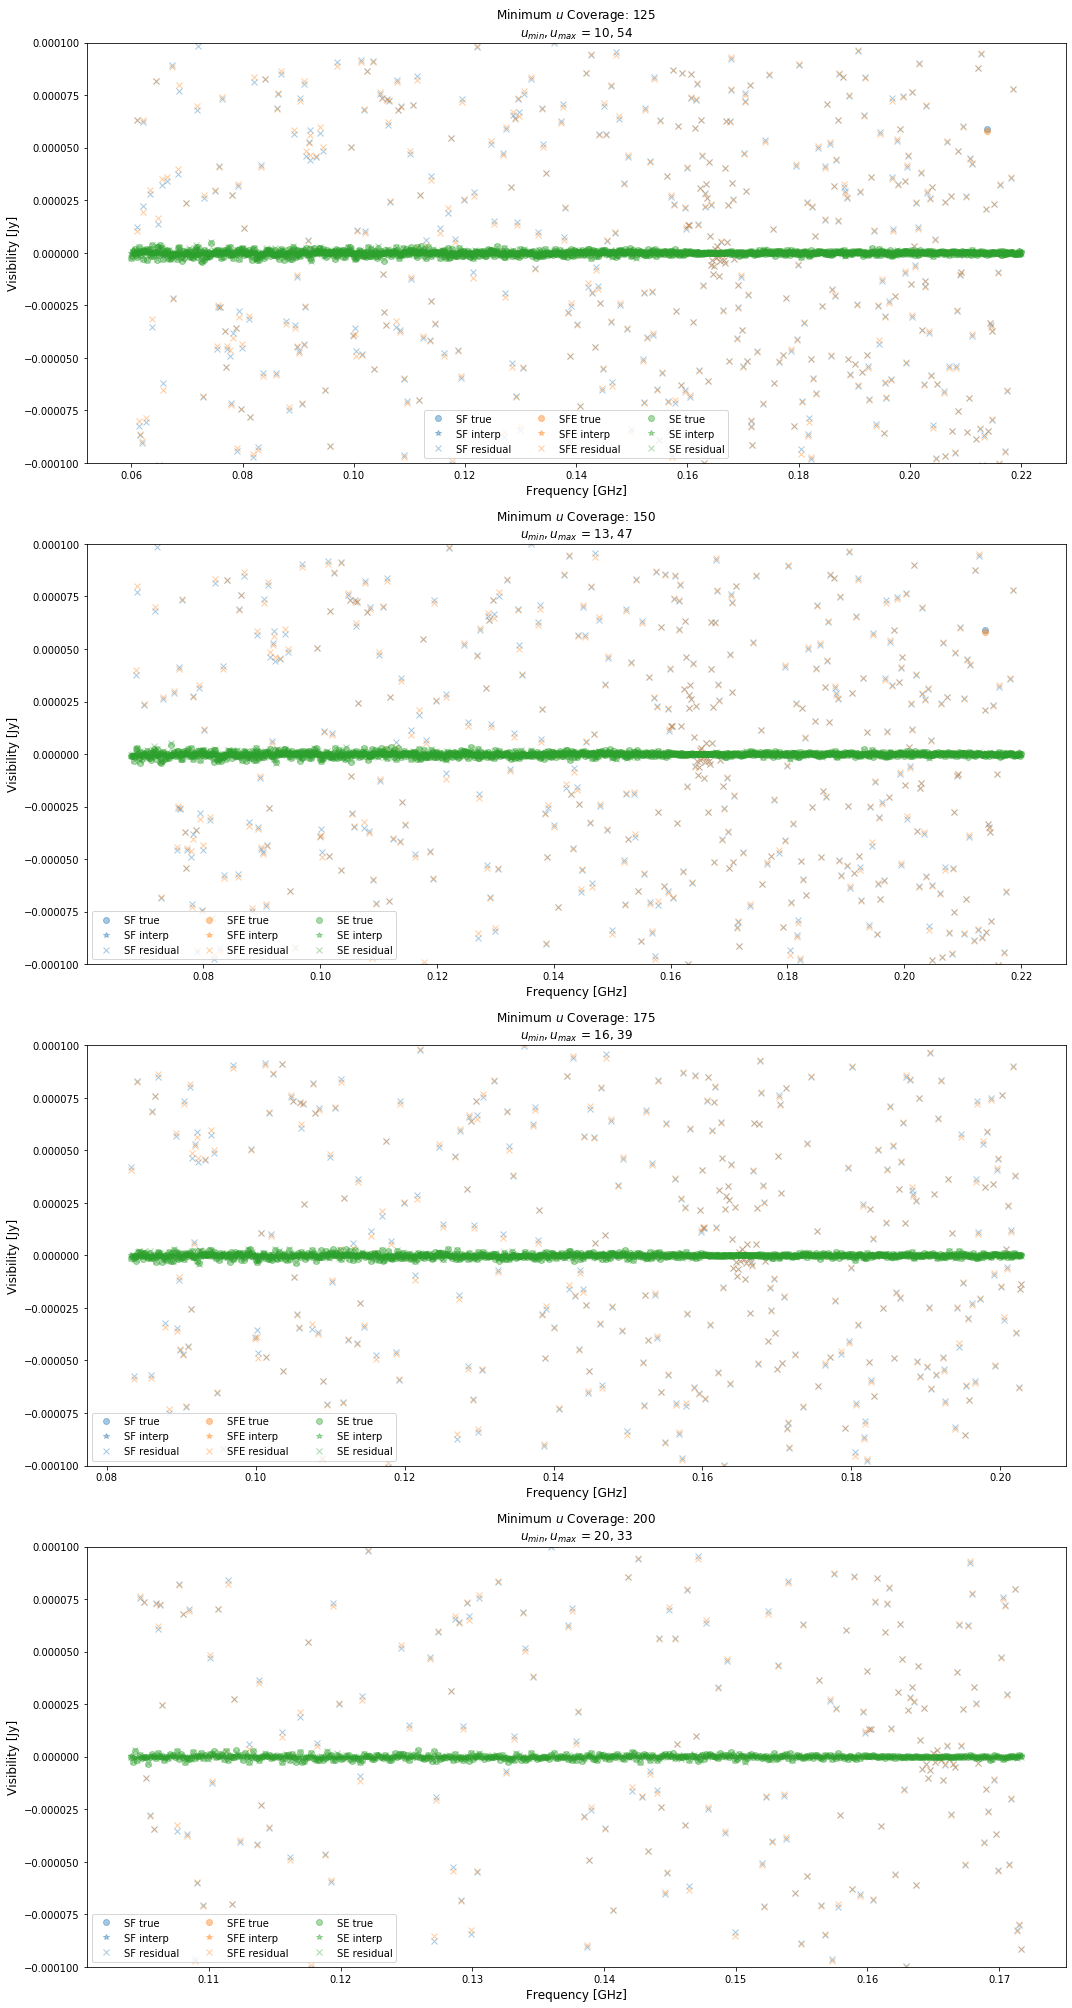

In [58]:
fig_w = 15
fig_h = 7
ybound = 1e-4
Nplots = len(interp_vis_by_u_cov)

fig = plt.figure(figsize=(fig_w, fig_h * Nplots))
axes = fig.subplots(Nplots)
for ax, u_coverage in zip(axes.ravel(), interp_vis_by_u_cov):
    interp_vis_dict = interp_vis_by_u_cov[u_coverage]
    metadata = interp_vis_dict['metadata']
    umin, umax = metadata['ubounds']
    ai, aj = metadata['baseline']
    bl_ns = np.abs(antpos[ai] - antpos[aj])[0]
    use_freqs = metadata['freqs']
    chans = get_good_channels(bl_ns, freqs, umin, umax)
    
    ax.set_xlabel("Frequency [GHz]", fontsize=12)
    ax.set_ylabel("Visibility [Jy]", fontsize=12)
    if ybound is not None:
        ax.set_ylim(-ybound, ybound)
    title = r"Minimum $u$ Coverage: %d" % u_coverage
    title += "\n"
    title += r"$u_{min}, u_{max}$ = %d, %d" % (umin, umax)
    ax.set_title(title, fontsize=12)
    
    for vis_key, interp_vis_ in interp_vis_dict.items():
        if vis_key == "metadata":
            continue
        
        truth = true_vis[vis_key[:2]][chans, ai, aj]
        if len(vis_key) == 3:
            truth += true_vis[vis_key[0] + vis_key[-1]][chans, ai, aj]
        truth = truth.flatten()
        residual = truth - interp_vis_
        
        ax.plot(use_freqs, truth, marker='o', lw=0, label=vis_key+" true", alpha=0.4)
        cycle_colors(ax)

        ax.plot(use_freqs, interp_vis_, marker='*', lw=0, label=vis_key+" interp", alpha=0.4)
        cycle_colors(ax)

        ax.plot(use_freqs, residual, marker='x', lw=0, label=vis_key+" residual", alpha=0.4)
        
    _ = ax.legend(ncol=3)
    
plt.tight_layout()

In [63]:
interp_vis_by_u_cov[125].keys()

dict_keys(['metadata', 'SF', 'SFE', 'SE'])

/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/lustre/aoc/projects/hera/rpascua/env/envs/hera/lib/python3.7/site-packages/numpy/core/_

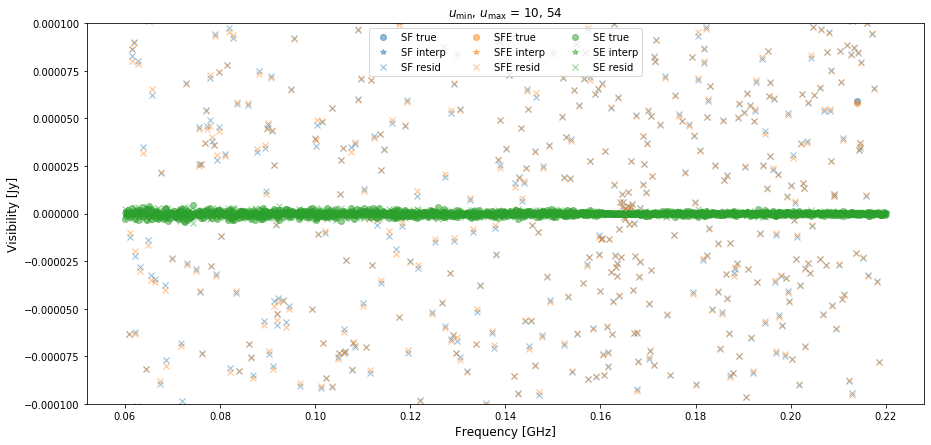

In [64]:
interp_vis = interp_vis_by_u_cov[125]
umin, umax = interp_vis['metadata']['ubounds']
ai, aj = interp_vis['metadata']['baseline']
bl_ns = np.linalg.norm(antpos[ai] - antpos[aj])
interp_chans = get_good_channels(bl_ns, freqs, umin, umax)
interp_freqs = interp_vis['metadata']['freqs']
alpha = 0.5

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [GHz]", fontsize=12)
ax.set_ylabel("Visibility [Jy]", fontsize=12)
ax.set_title(r"$u_\mathrm{min}$, $u_\mathrm{max}$ = %d, %d" % (umin, umax), fontsize=12)

ybound = 1e-4
if ybound is not None:
    ax.set_ylim(-ybound, ybound)
    
for bm_fg, vis_ in interp_vis.items():
    if bm_fg == 'metadata':
        continue
        
    truth = true_vis[bm_fg[:2]][interp_chans, ai, aj]
    if len(bm_fg) == 3:
        truth += true_vis[bm_fg[::2]][interp_chans, ai, aj]
        
    resid = vis_ - truth
    
    ax.plot(interp_freqs, truth, marker='o', lw=0, alpha=alpha, label=bm_fg+' true')
    cycle_colors(ax)
    ax.plot(interp_freqs, vis_, marker='*', lw=0, alpha=alpha, label=bm_fg+' interp')
    cycle_colors(ax)
    ax.plot(interp_freqs, resid, marker='x', lw=0, alpha=alpha, label=bm_fg+' resid')
    
_ = ax.legend(ncol=3)

In [65]:
# take a look at the fourier content of the visibilities pre/post filter
dlys = fourier_freqs(freqs) # ns

In [66]:
taper = gen_window('blackman-harris', freqs.size)
true_vis_fft = {
    vis_type : FFT(vis_ * taper[:, None, None], axis=0)
    for vis_type, vis_ in true_vis.items()
}

In [67]:
interp_dlys = fourier_freqs(interp_vis['metadata']['freqs'])
interp_taper = gen_window('blackman-harris', interp_dlys.size)
interp_vis_fft = {
    key : FFT(np.array(vis_) * interp_taper, axis=0)
    for key, vis_ in interp_vis.items()
    if key != 'metadata'
}

In [68]:
ai, aj = interp_vis['metadata']['baseline']
bl_ns = np.linalg.norm(antpos[ai] - antpos[aj])
umin, umax = interp_vis['metadata']['ubounds']
interp_chans = get_good_channels(bl_ns, freqs, umin, umax)

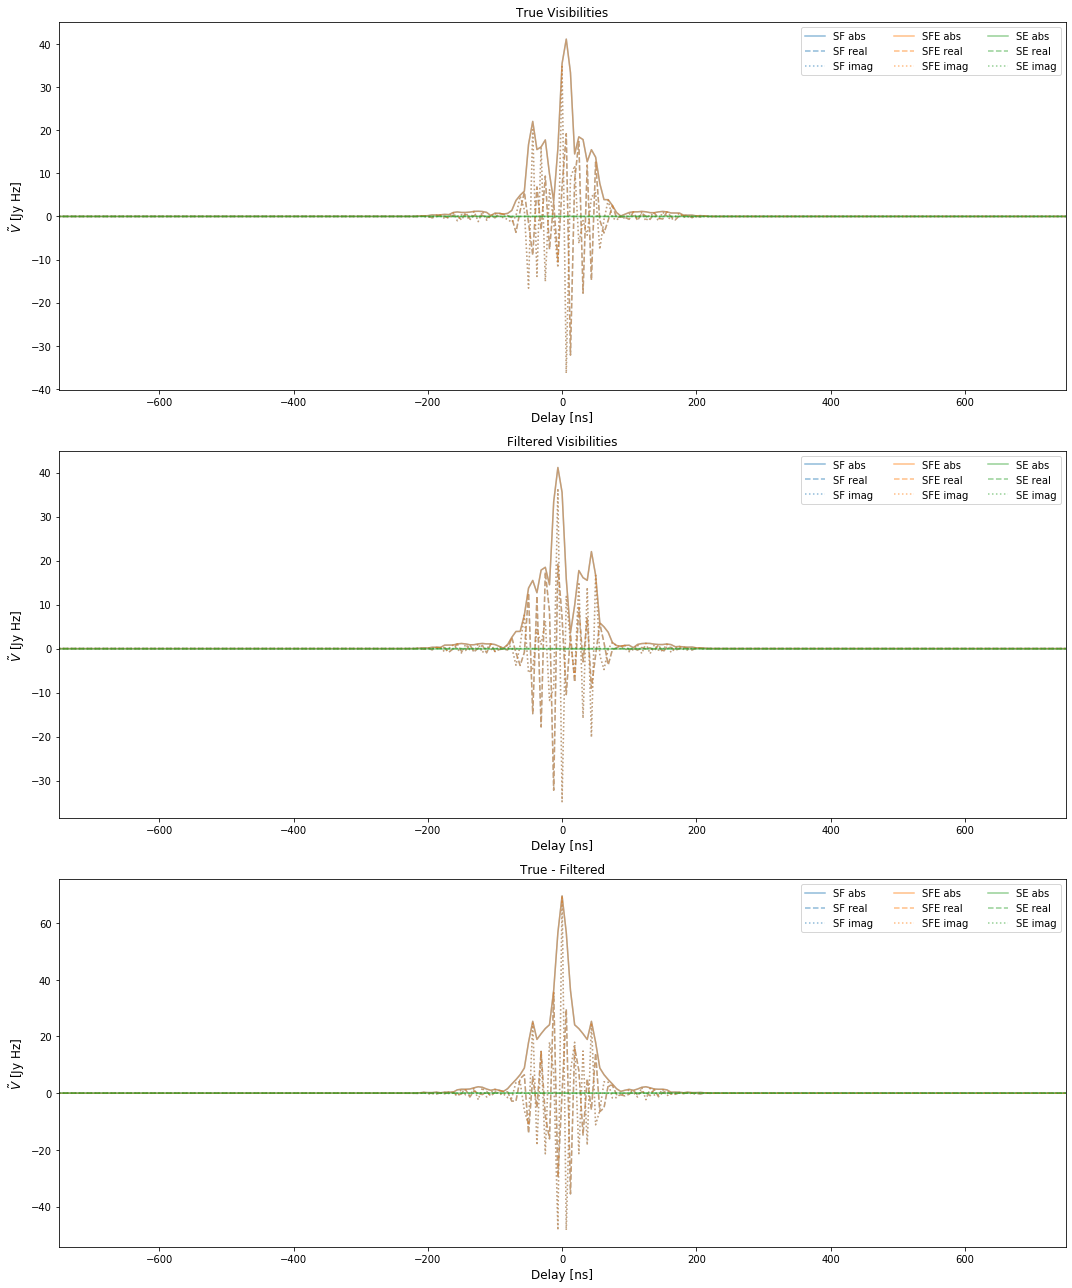

In [71]:
alpha = 0.5
dly_bound = 750 # ns
vis_bound = None
fig = plt.figure(figsize=(15,18))
axes = fig.subplots(3)
for ax in axes:
    ax.set_xlabel("Delay [ns]", fontsize=12)
    ax.set_ylabel(r"$\tilde{V}$ [Jy Hz]", fontsize=12)
    if dly_bound is not None:
        ax.set_xlim(-dly_bound, dly_bound)
    if vis_bound is not None:
        ax.set_ylim(-vis_bound, vis_bound)
    #ax.set_yscale('symlog')
    
axes[0].set_title("True Visibilities", fontsize=12)
axes[1].set_title("Filtered Visibilities", fontsize=12)
axes[2].set_title("True - Filtered", fontsize=12)

ai, aj = interp_vis['metadata']['baseline']
for bm_fg, vis_ in interp_vis_fft.items():
    truth_fft = true_vis_fft[bm_fg[:2]][:,ai,aj]
    truth = true_vis[bm_fg[:2]][interp_chans, ai, aj]
    if len(bm_fg) == 3:
        truth_fft += true_vis_fft[bm_fg[::2]][:,ai,aj]
        truth += true_vis[bm_fg[::2]][interp_chans, ai, aj]
    
    resid = truth - interp_vis[bm_fg]
    resid_fft = FFT(resid * interp_taper, axis=0)
    
    re_label = bm_fg + ' real'
    im_label = bm_fg + ' imag'
    abs_label = bm_fg + ' abs'
    pow_label = bm_fg + ' power'
    
    axes[0].plot(dlys, np.abs(truth_fft), alpha=alpha, label=abs_label)
    cycle_colors(axes[0])
    axes[0].plot(dlys, truth_fft.real, alpha=alpha, ls='--', label=re_label)
    cycle_colors(axes[0])
    axes[0].plot(dlys, truth_fft.imag, alpha=alpha, ls=':', label=im_label)
#    cycle_colors(axes[0])
#    axes[0].plot(dlys, np.abs(truth_fft)**2, alpha=alpha, ls='--', label=pow_label)
    
    axes[1].plot(interp_dlys, np.abs(vis_), alpha=alpha, label=abs_label)
    cycle_colors(axes[1])
    axes[1].plot(interp_dlys, vis_.real, alpha=alpha, ls='--', label=re_label)
    cycle_colors(axes[1])
    axes[1].plot(interp_dlys, vis_.imag, ls=':', alpha=alpha, label=im_label)
#    cycle_colors(axes[1])
#    axes[1].plot(interp_dlys, np.abs(vis_)**2, ls='--', alpha=alpha, label=pow_label)

    axes[2].plot(interp_dlys, np.abs(resid_fft), alpha=alpha, label=abs_label)
    cycle_colors(axes[2])
    axes[2].plot(interp_dlys, resid_fft.real, alpha=alpha, ls='--', label=re_label)
    cycle_colors(axes[2])
    axes[2].plot(interp_dlys, resid_fft.imag, ls=':', alpha=alpha, label=im_label)
#    cycle_colors(axes[2])
#    axes[2].plot(interp_dlys, np.abs(resid_fft)**2, ls='--', alpha=alpha, label=pow_label)
    
for ax in axes:
    _ = ax.legend(ncol=3)
    
fig.tight_layout()